In [ ]:
# Copyright © 2025 UChicago Argonne, LLC All right reserved
# Full license accessible at https://github.com/AdvancedPhotonSource/DONUT/blob/main/LICENSE

import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
import torch
import numpy as np
from math import *
import time
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import cmcrameri.cm as cmc

%matplotlib inline
plt.style.use('/home/beams/B313762/stylesheet.mplstyle')

## Load data + pre-processing

In [ ]:
data_folder = '/data/aileen/DONUT_data' 

sim_mat = np.load(os.path.join(data_folder, 'sim_SIO_4nm_range.npy')) # With thickness

sim_mat[np.isnan(sim_mat)] = 0
sim_mat /= sim_mat.sum(axis=(4, 5), keepdims=True)

sim_mat = np.reshape(sim_mat,
                     (sim_mat.shape[0]*sim_mat.shape[1]*sim_mat.shape[2]*sim_mat.shape[3], 
                     sim_mat.shape[4], sim_mat.shape[5]))
avg_max = np.mean(sim_mat.max(axis=(1, 2)))

print('Data shape: ', sim_mat.shape)

thickness = np.linspace(97, 137, 11)
strain = np.linspace(-0.005, 0.005, 21)
tilt_lr = np.linspace(-0.05, 0.05, 21)
tilt_ud = np.linspace(-0.1, 0.1, 21)

labels = np.zeros((11, 21, 21, 21, 4))
for p0 in range(labels.shape[0]):
    for p1 in range(labels.shape[1]):
        for p2 in range(labels.shape[2]):
            for p3 in range(labels.shape[3]):
                labels[p0, p1, p2, p3] = np.array([thickness[p0], strain[p1], tilt_lr[p2], tilt_ud[p3]])
labels = np.reshape(labels, (labels.shape[0]*labels.shape[1]*labels.shape[2]*labels.shape[3], 
                             labels.shape[4]))

labels = np.float32(np.around(labels, 5))

print('Labels shape: ', labels.shape)

# Normalize data from 0 to average experimental single shot maximum value
sim_mat_norm = np.zeros(sim_mat.shape)
for i in range(sim_mat_norm.shape[0]):
    sim_mat_norm[i] = (sim_mat[i] / avg_max) * 6
print('Normalized min. and max.: ', np.min(sim_mat_norm), np.max(sim_mat_norm))

# Add Poisson noise 
rng = np.random.default_rng()
for i in range(sim_mat_norm.shape[0]):
    sim_mat_norm[i] = rng.poisson(sim_mat_norm[i])

sim_mat_norm = sim_mat_norm.astype('float32')
print('Data type: ', sim_mat_norm.dtype)

Data shape:  (101871, 64, 64)
Labels shape:  (101871, 4)
Normalized min. and max.:  0.0 8.205474814919892
Data type:  float32


In [5]:
print('Loading raw experimental data')
data = np.load(os.path.join(data_folder, 'dataSIO.npy')).astype(np.float32)

print('Loading fitted data')
thickness_fit = np.load(os.path.join(data_folder, 'thickness_fit_SIO.npy'))
strain_fit = np.load(os.path.join(data_folder, 'strain_fit_SIO.npy'))
tilt_lr_fit = np.load(os.path.join(data_folder, 'tilt_lr_fit_SIO.npy'))
tilt_ud_fit = np.load(os.path.join(data_folder, 'tilt_ud_fit_SIO.npy'))

thickness_fit = np.reshape(thickness_fit, (165, 165))
strain_fit = np.reshape(strain_fit, (165, 165))
tilt_lr_fit = np.reshape(tilt_lr_fit, (165, 165))
tilt_ud_fit = np.reshape(tilt_ud_fit, (165, 165))

# These are relative quantities
strain_fit -= np.mean(strain_fit)
tilt_lr_fit -= np.mean(tilt_lr_fit)
tilt_ud_fit -= np.mean(tilt_ud_fit)

print('Loading simulated scan data')
sim_sample = np.load(os.path.join(data_folder, 'sim_sample_thickness.npy')).astype(np.float32)
sim_sample = np.reshape(sim_sample, (sim_sample.shape[0]*sim_sample.shape[1], sim_sample.shape[2], sim_sample.shape[3]))
sim_sample[np.isnan(sim_sample)] = 0
sim_sample /= sim_sample.sum(axis=(1, 2), keepdims=True)
avg_max_sample = np.mean(sim_sample.max(axis=(1, 2)))
sim_sample = (sim_sample / avg_max_sample) * 6
for i in range(sim_sample.shape[0]):
    sim_sample[i] = rng.poisson(sim_sample[i])

gt_thickness = np.load(os.path.join(data_folder, 'gt_thickness.npy'))
gt_strain = np.load(os.path.join(data_folder, 'gt_strain.npy'))
gt_tilt_lr = np.load(os.path.join(data_folder, 'gt_tilt_lr.npy'))
gt_tilt_ud = np.load(os.path.join(data_folder, 'gt_tilt_ud.npy'))

Loading raw experimental data
Loading fitted data
Loading simulated scan data


## Convert to PyTorch Dataset

In [6]:
class DiffDataset(Dataset):
    """Makes PyTorch Dataset object for diffraction data (images)."""
    
    def __init__(self, data, params=None, transform=None):
        self.data = data
        if isinstance(params, np.ndarray):
            self.params = params
        else:
            self.params = None
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        image = self.data[idx]
        if isinstance(self.params, np.ndarray):
            lattice = self.params[idx]
            sample={'image': image, 'lattice': lattice}
        else:
            sample = {'image': image, 'lattice': None}
            
        if self.transform:
            sample = self.transform(sample)
        return sample
    
class ToTensor(object):
    """Convert numpy arrays to Tensors"""
    def __call__(self, sample):
        image = sample['image']
        if isinstance(sample['lattice'], np.ndarray):
            lattice = sample['lattice']
            return {'image': torch.unsqueeze(torch.from_numpy(image), 0), 'lattice': torch.from_numpy(lattice)}
        return {'image': torch.unsqueeze(torch.from_numpy(image), 0), 'lattice': 0}

In [7]:
diff_dataset = DiffDataset(data=sim_mat_norm, params=labels, transform=ToTensor())
exp_dataset = DiffDataset(data=data, params=None, transform=ToTensor())
sim_dataset = DiffDataset(data=sim_sample, params=None, transform=ToTensor())

for i, sample in enumerate(exp_dataset):
    print(i, sample['image'].size())
    print(sample['image'].dtype)
    
    if i == 4:
        break

0 torch.Size([1, 64, 64])
torch.float32
1 torch.Size([1, 64, 64])
torch.float32
2 torch.Size([1, 64, 64])
torch.float32
3 torch.Size([1, 64, 64])
torch.float32
4 torch.Size([1, 64, 64])
torch.float32


In [8]:
# Split into training, validation, and test sets

generator0 = torch.Generator().manual_seed(8)
subsets = torch.utils.data.random_split(diff_dataset, [0.8, 0.1, 0.1], generator=generator0)

## Hyperparameters and constants

In [9]:
BATCH_SIZE = 64
MODEL_SAVE_PATH = './models/thickness_sim_noisy'

In [10]:
# Use a DataLoader to iterate through the Dataset
trainloader = DataLoader(subsets[0], batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(subsets[1], batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(subsets[2], batch_size=BATCH_SIZE, shuffle=False)

dataloader = DataLoader(exp_dataset, batch_size=BATCH_SIZE, shuffle=False)

simloader = DataLoader(sim_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Model definition

In [11]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, dropout_rate=0.0):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(), 
            nn.Dropout(dropout_rate),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        
    def forward(self, x: torch.Tensor):
        return self.conv(x)

# Autoencoder building blocks
class DownSample(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d((2, 2))
        
    def forward(self, x: torch.Tensor):
        return self.pool(x)
    
class UpSample(nn.Module):
    def __init__(self):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear')
        
    def forward(self, x: torch.Tensor):
        return self.up(x)
    
class DoubleConvUp(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, dropout_rate=0.0):
        super().__init__()
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.ConvTranspose2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(), 
            nn.Dropout(dropout_rate)
        )
        
    def forward(self, x: torch.Tensor):
        return self.conv(x)

In [12]:
class Encoder(nn.Module):
    def __init__(self, in_channels: int, dropout_rate=0.0):
        super().__init__()
        self.down_conv = nn.ModuleList([DoubleConv(i, o, dropout_rate) for i, o in 
                                        [(in_channels, 16), (16, 32), (32, 64), (64, 128), (128, 256), 
                                         (256, 256)]])
        self.down_sample = nn.ModuleList([DownSample() for _ in range(6)])
        self.fc = nn.Linear(256, 4)
        
    def forward(self, x: torch.Tensor):
        for i in range(len(self.down_conv)):
            x = self.down_conv[i](x)
            x = self.down_sample[i](x)
            #print(x.shape)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self, out_channels: int, dropout_rate=0.0):
        super().__init__()
        self.up_sample = UpSample()
        self.up_conv = nn.ModuleList([DoubleConvUp(i, o, dropout_rate) for i, o in 
                                      [(256, 256), (256, 128), (128, 64), (64, 32), (32, 16), 
                                       (16, out_channels)]])
        self.inv_fc = nn.Linear(4, 256)
        
    def forward(self, x: torch.Tensor):
        x = self.inv_fc(x)
        x = x.view(x.shape[0], 256, 1, 1)
        for i in range(len(self.up_conv)):
            x = self.up_sample(x)
            x = self.up_conv[i](x)
            #print(x.shape)
        return x

## Visualizations

In [13]:
import pickle

with open(os.path.join(MODEL_SAVE_PATH, 'metrics_thickness_sim.pickle'), 'rb') as file:
    metrics = pickle.load(file)

metrics.keys()

dict_keys(['losses', 'decoder_loss', 'sim_loss', 'val_losses', 'best_val_loss', 'enc_lrs', 'dec_lrs'])

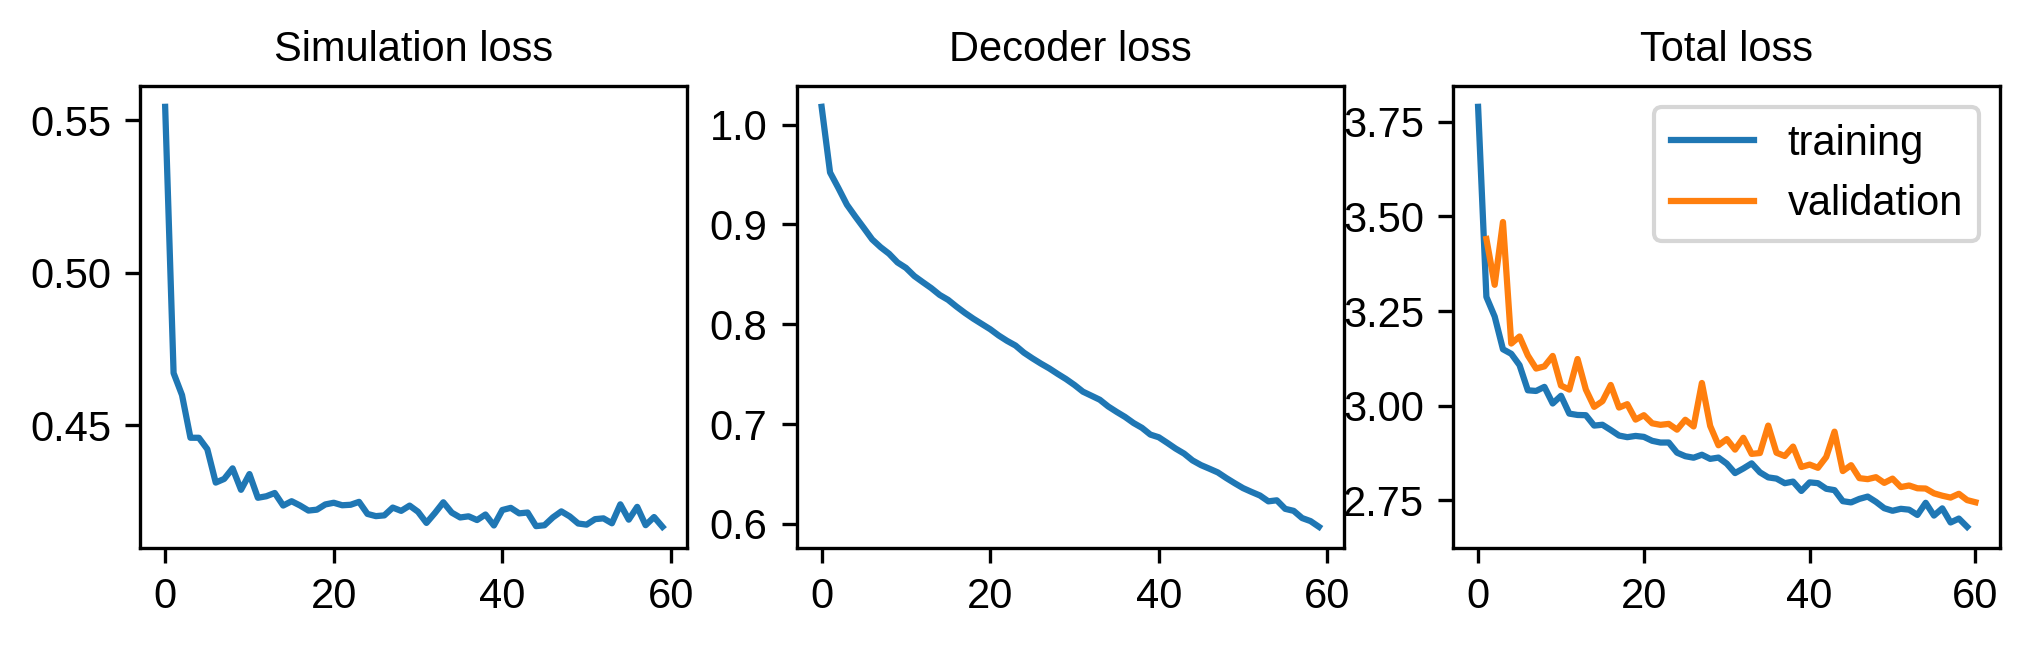

In [14]:
f, ax = plt.subplots(figsize=(8, 2), ncols=3)

ax[0].plot(metrics['sim_loss'])
ax[0].set_title('Simulation loss')
ax[1].plot(metrics['decoder_loss'])
ax[1].set_title('Decoder loss')
ax[2].plot(metrics['losses'], label='training')
ax[2].plot(metrics['val_losses'], label='validation')
ax[2].set_title('Total loss')
ax[2].legend()

In [15]:
#cnn = DonutNN2(1, 1)
cnn = Encoder(1)
cnn.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, 'best_model_encoder.pth'), 
                               map_location=torch.device('cpu')))
scale_factor = torch.tensor([np.log(50), np.log(5e-3), np.log(5e-2), np.log(1e-1)])
next(cnn.parameters()).device

device(type='cpu')

In [16]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#DEVICE = "cpu"

def get_predictions(model, dataloader, scale, encoder_only=True, batch_size=BATCH_SIZE, device=DEVICE):
    """Returns network predictions and labels by any model on any dataset."""
    
    pred_vals = np.zeros((len(dataloader)-1, batch_size, 4))
    if encoder_only == False:
        pred_imgs = np.zeros((len(dataloader)-1, batch_size, 64, 64))
        pred_recon = np.zeros((len(dataloader)-1, batch_size, 64, 64))
        gt_imgs = np.zeros(pred_imgs.shape)
    gt_vals = np.zeros(pred_vals.shape)
    model.to(device)
    print(next(model.parameters()).device)
    inference_time = []
    t0 = time.time()
    
    model.eval()
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader)):
            t1 = time.time()
            images = data['image'].to(device)
            scale_factor = scale.to(device)
            if isinstance(data['lattice'], torch.Tensor):
                labels = data['lattice'].to(device)
            if encoder_only == False:
                output_recon, output_imgs, output_vals = model(images)
            else: 
                output_enc = model(images)
                constrained_params = 1.7159 * torch.tanh((2/3) * output_enc)
                output_vals = constrained_params * torch.exp(scale_factor)
            if i < pred_vals.shape[0]:
                pred_vals[i] = output_vals.detach().cpu().numpy()
                if encoder_only == False:
                    pred_imgs[i] = output_imgs.squeeze().detach().cpu().numpy()
                    pred_recon[i] = output_recon.squeeze().detach().cpu().numpy()
                    gt_imgs[i] = images.squeeze().detach().cpu().numpy()
                if isinstance(data['lattice'], torch.Tensor) and data['lattice'].shape==(data['lattice'].shape[0], 4):
                    gt_vals[i] = labels.detach().cpu().numpy()
                inference_time.append(time.time()-t1)
            else:
                # The last batch may be a different size
                pred_vals_last = output_vals.detach().cpu().numpy()
                if encoder_only == False:
                    pred_imgs_last = output_imgs.squeeze(dim=1).detach().cpu().numpy()
                    pred_recon_last = output_recon.squeeze(dim=1).detach().cpu().numpy()
                    gt_imgs_last = images.squeeze().detach().cpu().numpy()
                    if gt_imgs_last.ndim == 2:
                        gt_imgs_last = gt_imgs_last[np.newaxis, :, :]
                if isinstance(data['lattice'], torch.Tensor) and data['lattice'].shape==(data['lattice'].shape[0], 4):
                    gt_vals_last = labels.detach().cpu().numpy()
                inference_time.append(time.time()-t1)
    
    print('Total inference time (s): ', time.time()-t0)
    print('Average inference time (s): ', np.mean(inference_time[2:len(inference_time)-1])/batch_size)
    print('Inference time error (s): ', np.std(inference_time[2:len(inference_time)-1])/batch_size)
    pred_vals = np.reshape(pred_vals, (pred_vals.shape[0]*pred_vals.shape[1], pred_vals.shape[2]))
    if encoder_only == False:
        pred_imgs = np.reshape(pred_imgs, (pred_imgs.shape[0]*pred_imgs.shape[1], 
                                           pred_imgs.shape[2], pred_imgs.shape[3]))
        pred_recon = np.reshape(pred_recon, (pred_recon.shape[0]*pred_recon.shape[1], pred_recon.shape[2],
                                             pred_recon.shape[3]))
        gt_imgs = np.reshape(gt_imgs, (gt_imgs.shape[0]*gt_imgs.shape[1], gt_imgs.shape[2], gt_imgs.shape[3]))
        pred_imgs = np.vstack((pred_imgs, pred_imgs_last))
        pred_recon = np.vstack((pred_recon, pred_recon_last))
        gt_imgs = np.vstack((gt_imgs, gt_imgs_last))
    gt_vals = np.reshape(gt_vals, (gt_vals.shape[0]*gt_vals.shape[1], gt_vals.shape[2]))
    pred_vals = np.vstack((pred_vals, pred_vals_last))
    if isinstance(data['lattice'], torch.Tensor) and data['lattice'].shape==(data['lattice'].shape[0], 4):
        gt_vals = np.vstack((gt_vals, gt_vals_last))
    if encoder_only == False:
        return pred_vals, pred_imgs, pred_recon, gt_vals, gt_imgs
    return pred_vals, gt_vals

In [17]:
pred_vals_train, gt_vals_train = get_predictions(cnn, trainloader, scale=scale_factor, encoder_only=True)

cuda:0


0it [00:00, ?it/s]

Total inference time (s):  8.522064447402954
Average inference time (s):  2.6019775168713767e-05
Inference time error (s):  1.9034119013128854e-06


In [18]:
pred_vals_test, gt_vals_test = get_predictions(cnn, testloader, scale=scale_factor, encoder_only=True)

cuda:0


0it [00:00, ?it/s]

Total inference time (s):  0.7997744083404541
Average inference time (s):  2.3609798425322124e-05
Inference time error (s):  1.3928118632641606e-07


In [19]:
pred_vals_sim, _ = get_predictions(cnn, simloader, scale=scale_factor, encoder_only=True)

cuda:0


0it [00:00, ?it/s]

Total inference time (s):  0.13296127319335938
Average inference time (s):  2.3350547083088607e-05
Inference time error (s):  2.1950791335110978e-07


In [20]:
pred_sim_thickness = np.reshape(pred_vals_sim[:, 0], (64, 64))
pred_sim_strain = np.reshape(pred_vals_sim[:, 1], (64, 64))
pred_sim_tilt_lr = np.reshape(pred_vals_sim[:, 2], (64, 64))
pred_sim_tilt_ud = np.reshape(pred_vals_sim[:, 3], (64, 64))

[]

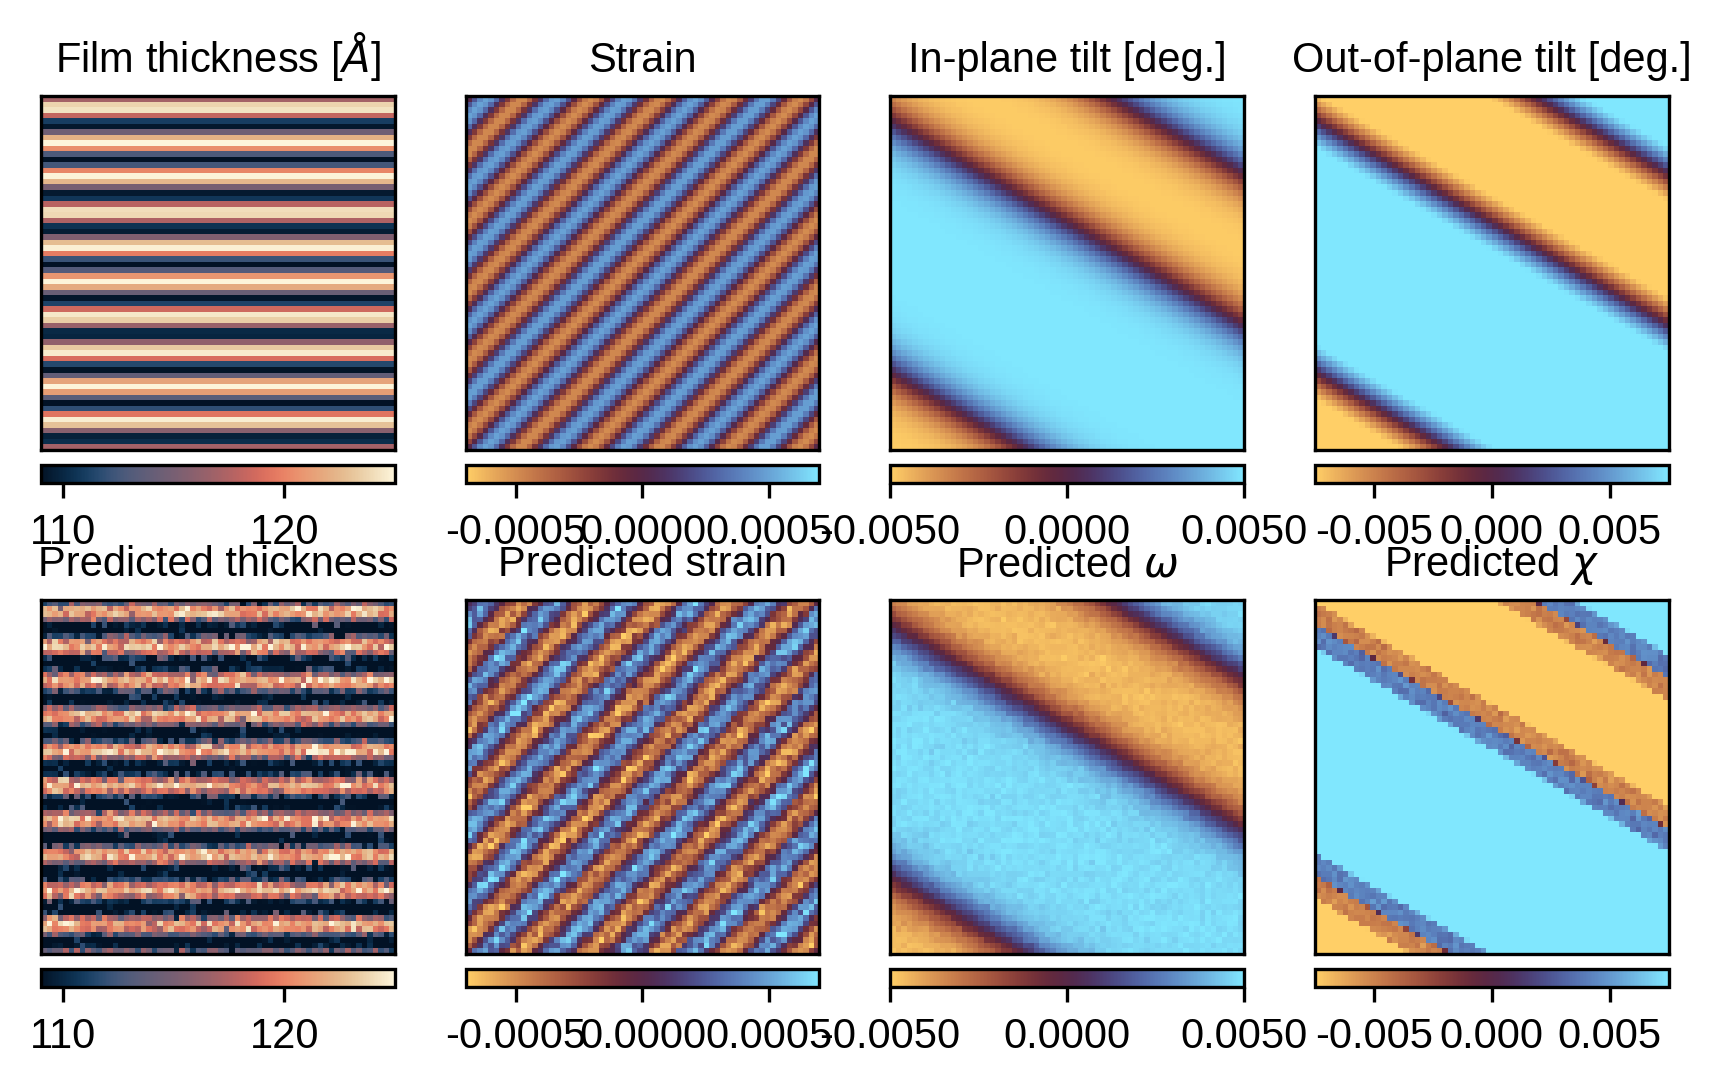

In [21]:
# Refer to Fig. 4a, S5a
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 'truetype'

f, ax = plt.subplots(figsize=(7, 4), nrows=2, ncols=4)

vmin0 = 109
vmax0 = 125
vmin1 = -0.0007 # np.mean(pred_sim_strain) - (2 * np.std(pred_sim_strain))
vmax1 = 0.0007 # np.mean(pred_sim_strain) + (2 * np.std(pred_sim_strain))
vmin2 = -0.005 # np.mean(pred_sim_tilt_lr) - (2 * np.std(pred_sim_tilt_lr))
vmax2 = 0.005 # np.mean(pred_sim_tilt_lr) + (2 * np.std(pred_sim_tilt_lr))
vmin3 = -0.0075 # np.mean(pred_sim_tilt_ud) - (2 * np.std(pred_sim_tilt_ud))
vmax3 = 0.0075 # np.mean(pred_sim_tilt_ud) + (2 * np.std(pred_sim_tilt_ud))

im0 = ax[0, 0].imshow(gt_thickness, interpolation='none', cmap=cmc.lipari, vmin=vmin0, vmax=vmax0)
divider = make_axes_locatable(ax[0, 0])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(im0, cax=cax, orientation='horizontal')
ax[0, 0].set_title('Film thickness [$\AA$]')
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

im1 = ax[0, 1].imshow(gt_strain, interpolation='none', cmap=cmc.managua, 
                      vmin=vmin1, vmax=vmax1)
divider = make_axes_locatable(ax[0, 1])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(im1, cax=cax, orientation='horizontal', format='%.4f')
ax[0, 1].set_title('Strain')
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])

im2 = ax[0, 2].imshow(gt_tilt_lr, interpolation='none', cmap=cmc.managua, 
                      vmin=vmin2, vmax=vmax2)
divider = make_axes_locatable(ax[0, 2])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(im2, cax=cax, orientation='horizontal', format='%.4f')
ax[0, 2].set_title('In-plane tilt [deg.]')
ax[0, 2].set_xticks([])
ax[0, 2].set_yticks([])

im3 = ax[0, 3].imshow(gt_tilt_ud, interpolation='none', cmap=cmc.managua, 
                      vmin=vmin3, vmax=vmax3)
divider = make_axes_locatable(ax[0, 3])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(im3, cax=cax, orientation='horizontal', format='%.3f')
ax[0, 3].set_title('Out-of-plane tilt [deg.]')
ax[0, 3].set_xticks([])
ax[0, 3].set_yticks([])

pred0 = ax[1, 0].imshow(pred_sim_thickness+117, interpolation='none', cmap=cmc.lipari, vmin=vmin0, vmax=vmax0)
divider = make_axes_locatable(ax[1, 0])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(pred0, cax=cax, orientation='horizontal')
ax[1, 0].set_title('Predicted thickness')
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])

pred1 = ax[1, 1].imshow(pred_sim_strain, interpolation='none', cmap=cmc.managua, 
                        vmin=vmin1, vmax=vmax1)
divider = make_axes_locatable(ax[1, 1])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(pred1, cax=cax, orientation='horizontal', format='%.4f')
ax[1, 1].set_title('Predicted strain')
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])

pred2 = ax[1, 2].imshow(pred_sim_tilt_lr, interpolation='none', cmap=cmc.managua, 
                        vmin=vmin2, vmax=vmax2)
divider = make_axes_locatable(ax[1, 2])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(pred2, cax=cax, orientation='horizontal', format='%.4f')
ax[1, 2].set_title('Predicted $\omega$')
ax[1, 2].set_xticks([])
ax[1, 2].set_yticks([])

pred3 = ax[1, 3].imshow(pred_sim_tilt_ud, interpolation='none', cmap=cmc.managua, 
                        vmin=vmin3, vmax=vmax3)
divider = make_axes_locatable(ax[1, 3])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(pred3, cax=cax, orientation='horizontal', format='%.3f')
ax[1, 3].set_title('Predicted $\chi$')
ax[1, 3].set_xticks([])
ax[1, 3].set_yticks([])

#f.savefig('fig4a.svg', dpi=300, bbox_inches='tight', transparent=True)

In [22]:
thickness_label_range = np.linspace(97, 137, 11)
print('Thickness label range: ', thickness_label_range)
strain_label_range = np.linspace(-0.005, 0.005, 21)
print('Strain label range: ', strain_label_range)
tilt_lr_label_range = np.linspace(-0.05, 0.05, 21)
print('Tilt_lr label range: ', tilt_lr_label_range)
tilt_ud_label_range = np.linspace(-0.1, 0.1, 21)
print('Tilt_ud label range: ', tilt_ud_label_range)

Thickness label range:  [ 97. 101. 105. 109. 113. 117. 121. 125. 129. 133. 137.]
Strain label range:  [-0.005  -0.0045 -0.004  -0.0035 -0.003  -0.0025 -0.002  -0.0015 -0.001
 -0.0005  0.      0.0005  0.001   0.0015  0.002   0.0025  0.003   0.0035
  0.004   0.0045  0.005 ]
Tilt_lr label range:  [-0.05  -0.045 -0.04  -0.035 -0.03  -0.025 -0.02  -0.015 -0.01  -0.005
  0.     0.005  0.01   0.015  0.02   0.025  0.03   0.035  0.04   0.045
  0.05 ]
Tilt_ud label range:  [-0.1  -0.09 -0.08 -0.07 -0.06 -0.05 -0.04 -0.03 -0.02 -0.01  0.    0.01
  0.02  0.03  0.04  0.05  0.06  0.07  0.08  0.09  0.1 ]


In [23]:
def make_idx_dict(label_arr):
    """Returns three dictionaries with labels as keys and numpy arrays of indices where the label is the key.
    label_arr: numpy array of labels
    """
    idx_dict_t = dict.fromkeys(thickness_label_range, [])
    idx_dict_s = dict.fromkeys(strain_label_range, [])
    idx_dict_lr = dict.fromkeys(tilt_lr_label_range, [])
    idx_dict_ud = dict.fromkeys(tilt_ud_label_range, [])
    
    for thickness_label in thickness_label_range:
        val_arr = np.argwhere(np.around(label_arr[:, 0], 1) == np.around(thickness_label, 1))
        idx_dict_t[thickness_label] = val_arr
    for strain_label in strain_label_range:
        val_arr = np.argwhere(np.around(label_arr[:, 1], 4) == np.around(strain_label, 4))
        idx_dict_s[strain_label] = val_arr
    for lr_label in tilt_lr_label_range:
        val_arr = np.argwhere(np.around(label_arr[:, 2], 3) == np.around(lr_label, 3))
        idx_dict_lr[lr_label] = val_arr
    for ud_label in tilt_ud_label_range:
        val_arr = np.argwhere(np.around(label_arr[:, 3], 3) == np.around(ud_label, 3))
        idx_dict_ud[ud_label] = val_arr
    return idx_dict_t, idx_dict_s, idx_dict_lr, idx_dict_ud

def test_make_idx_dict(idx_dict):
    """Return the total number of indices accounted for. It should be equal to the total number of labels."""
    counter = 0
    for key in idx_dict.keys():
        counter += len(idx_dict[key])
    return counter

In [24]:
# Make dictionaries for training and test labels
train_t, train_s, train_lr, train_ud = make_idx_dict(gt_vals_train)
print('Train set indices: ', test_make_idx_dict(train_t), test_make_idx_dict(train_s), 
      test_make_idx_dict(train_lr), test_make_idx_dict(train_ud))
test_t, test_s, test_lr, test_ud = make_idx_dict(gt_vals_test)
print('Test set indices: ', test_make_idx_dict(test_t), test_make_idx_dict(test_s), 
      test_make_idx_dict(test_lr), test_make_idx_dict(test_ud))

Train set indices:  81497 81497 81497 81497
Test set indices:  10187 10187 10187 10187


In [25]:
def get_pred_err_stats(idx_arr, pred_arr, param_num):
    """Returns the mean and standard deviation of the prediction error for all parameters. Helper function for 
    combine_stats.
    idx_arr: array of indices
    pred_arr: array of predictions on a set of data
    param_num: 0 = thickness, 1 = strain, 2 = tilt_lr, 3 = tilt_ud
    """
    temp = np.zeros((idx_arr.shape[0], ))
    j = 0
    for idx in idx_arr:
        temp[j] = pred_arr[idx[0], param_num]
        j += 1
    return np.mean(temp), np.std(temp)

def combine_stats(idx_dict_t, idx_dict_s, idx_dict_lr, idx_dict_ud, pred_arr):
    """Combines the prediction errors of a parameter into an array using indices taken from the keys of the
    index dictionaries.
    idx_dict_t: dictionary of thickness label values (keys) and index positions (values)
    idx_dict_s: dictionary of strain label values (keys) and index positions (values)
    idx_dict_lr: dictionary of tilt_lr label values and index positions
    idx_dict_ud: dictionary of tilt_ud label values and index positions
    pred_arr: array of predictions on a set of data
    """
    stats_arr_t = np.zeros((len(idx_dict_t), 2))
    stats_arr_s = np.zeros((len(idx_dict_s), 2))
    stats_arr_lr = np.zeros((len(idx_dict_lr), 2))
    stats_arr_ud = np.zeros((len(idx_dict_ud), 2))
    counter_t = 0
    counter_s = 0
    counter_lr = 0
    counter_ud = 0
    for key in idx_dict_t.keys():
        i_arr = idx_dict_t[key]
        avg, stddev = get_pred_err_stats(i_arr, pred_arr, 0)
        stats_arr_t[counter_t, 0] = avg
        stats_arr_t[counter_t, 1] = stddev
        counter_t += 1
    for key in idx_dict_s.keys():
        i_arr = idx_dict_s[key]
        avg, stddev = get_pred_err_stats(i_arr, pred_arr, 1)
        stats_arr_s[counter_s, 0] = avg
        stats_arr_s[counter_s, 1] = stddev
        counter_s += 1
    for key in idx_dict_lr.keys():
        i_arr = idx_dict_lr[key]
        avg, stddev = get_pred_err_stats(i_arr, pred_arr, 2)
        stats_arr_lr[counter_lr, 0] = avg
        stats_arr_lr[counter_lr, 1] = stddev
        counter_lr += 1
    for key in idx_dict_ud.keys():
        i_arr = idx_dict_ud[key]
        avg, stddev = get_pred_err_stats(i_arr, pred_arr, 3)
        stats_arr_ud[counter_ud, 0] = avg
        stats_arr_ud[counter_ud, 1] = stddev
        counter_ud += 1
    return stats_arr_t, stats_arr_s, stats_arr_lr, stats_arr_ud

In [26]:
# Make arrays of mean and std. dev. of predictions for each parameter and label value for ease of plotting

train_stats_t, train_stats_s, train_stats_lr, train_stats_ud = combine_stats(train_t, train_s, train_lr, 
                                                                             train_ud, pred_vals_train)
test_stats_t, test_stats_s, test_stats_lr, test_stats_ud = combine_stats(test_t, test_s, test_lr, test_ud, 
                                                                         pred_vals_test)

Text(0.5, 0.98, 'Trained on simulation only')

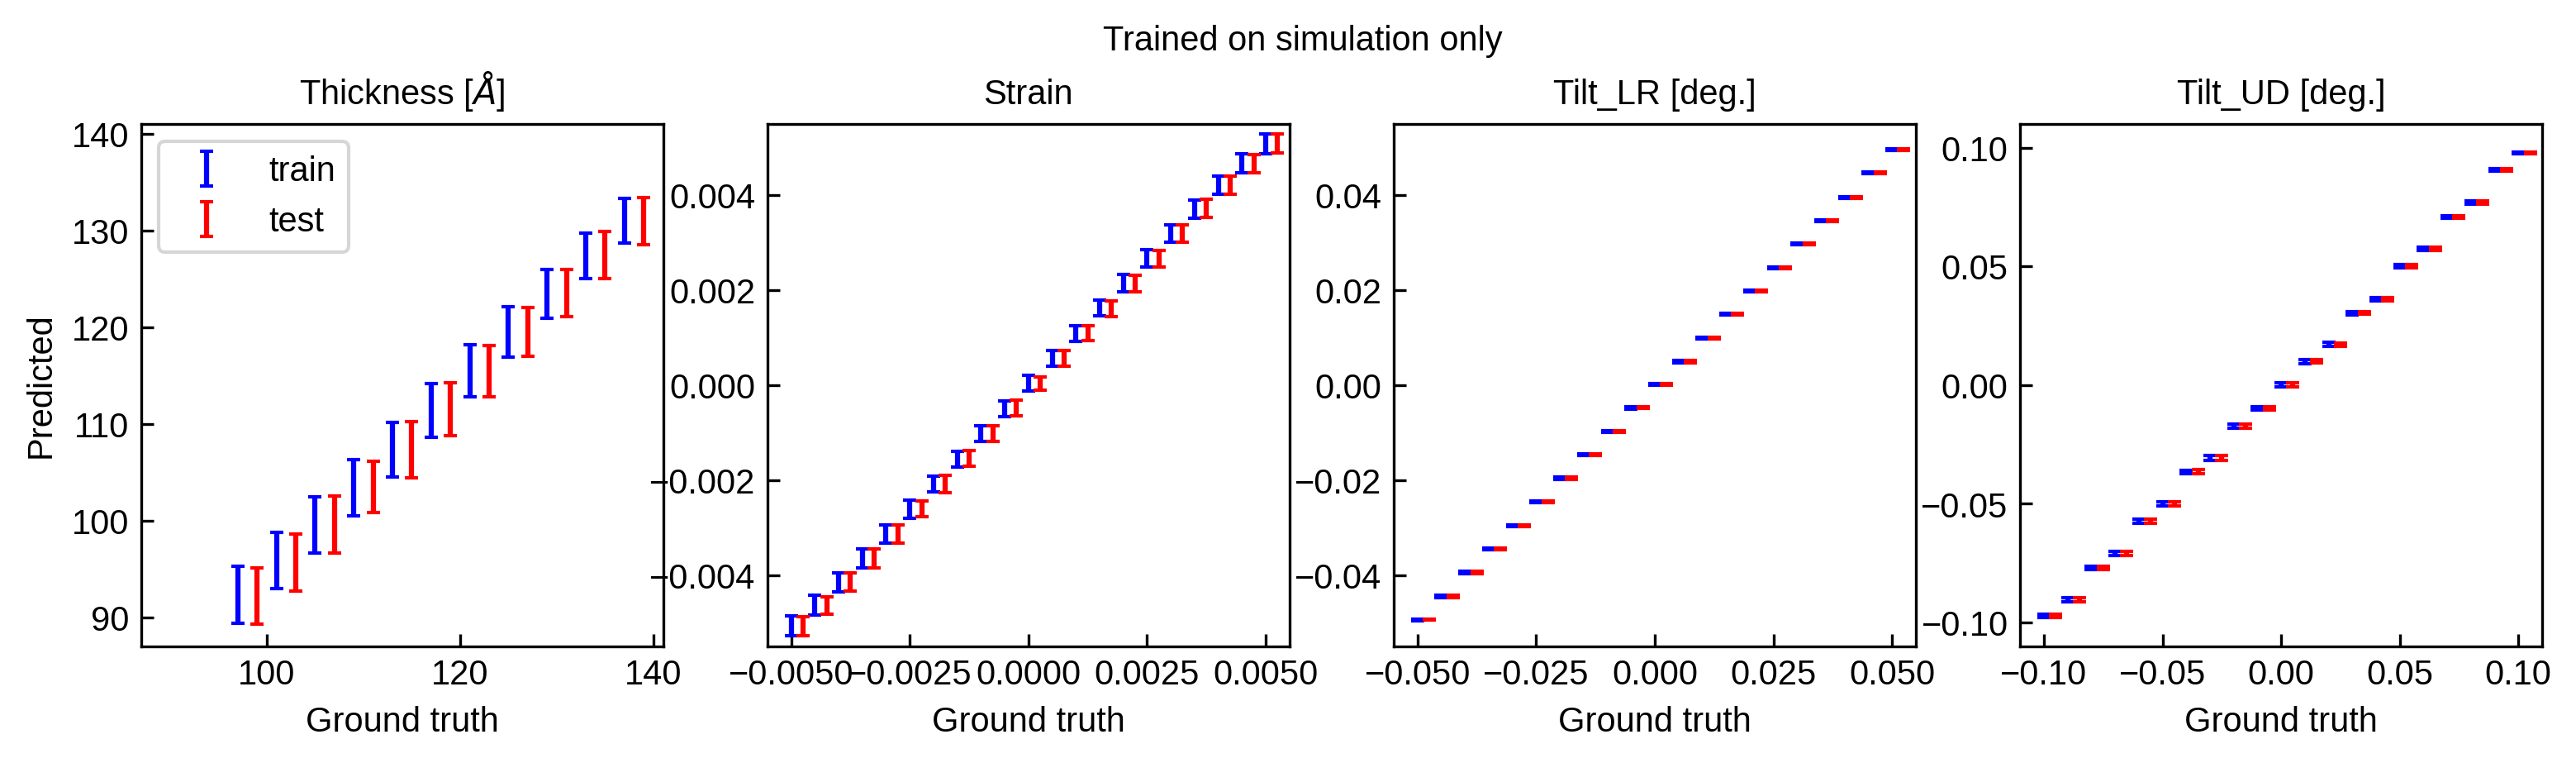

In [27]:
# Figure S5b
matplotlib.rcParams['pdf.fonttype'] = 'truetype'

f, ax = plt.subplots(figsize=(12.5, 3), ncols=4)

ax[0].errorbar(thickness_label_range, train_stats_t[:, 0]+117, yerr=train_stats_t[:, 1], 
               label='train', fmt='none', capsize=2, color='blue')
ax[0].errorbar(thickness_label_range+2, test_stats_t[:, 0]+117, 
               yerr=test_stats_t[:, 1], label='test', fmt='none', capsize=2, color='red')
ax[0].set_xlim([87, 141])
ax[0].set_ylim([87, 141])
ax[0].set_xlabel('Ground truth')
ax[0].set_ylabel('Predicted')
ax[0].set_title('Thickness [$\AA$]')
ax[0].set_aspect(1)
ax[0].tick_params(which='both', direction='in')
ax[0].legend()

ax[1].errorbar(np.linspace(-0.005, 0.005, 21), train_stats_s[:, 0], yerr=train_stats_s[:, 1], 
               label='train', fmt='none', capsize=2, color='blue')
ax[1].errorbar(np.linspace(-0.005, 0.005, 21)+0.00025, test_stats_s[:, 0], yerr=test_stats_s[:, 1], 
               label='test', fmt='none', capsize=2, color='red')
ax[1].set_xlim([-0.0055, 0.0055])
ax[1].set_ylim([-0.0055, 0.0055])
ax[1].set_xlabel('Ground truth')
ax[1].set_title('Strain')
ax[1].tick_params(which='both', direction='in')
ax[1].set_aspect(1)

ax[2].errorbar(np.linspace(-0.05, 0.05, 21), train_stats_lr[:, 0], yerr=train_stats_lr[:, 1], 
               label='train', fmt='none', capsize=2, color='blue')
ax[2].errorbar(np.linspace(-0.05, 0.05, 21)+0.0025, test_stats_lr[:, 0], yerr=test_stats_lr[:, 1], 
               label='test', fmt='none', capsize=2, color='red')
ax[2].set_xlim([-0.055, 0.055])
ax[2].set_ylim([-0.055, 0.055])
ax[2].set_xlabel('Ground truth')
ax[2].set_title('Tilt_LR [deg.]')
ax[2].tick_params(which='both', direction='in')
ax[2].set_aspect(1)

ax[3].errorbar(np.linspace(-0.1, 0.1, 21), train_stats_ud[:, 0], yerr=train_stats_ud[:, 1], 
               label='train', fmt='none', capsize=2, color='blue')
ax[3].errorbar(np.linspace(-0.1, 0.1, 21)+0.005, test_stats_ud[:, 0], yerr=test_stats_ud[:, 1], 
               label='test', fmt='none', capsize=2, color='red')
ax[3].set_xlim([-0.11, 0.11])
ax[3].set_ylim([-0.11, 0.11])
ax[3].set_xlabel('Ground truth')
ax[3].set_title('Tilt_UD [deg.]')
ax[3].tick_params(which='both', direction='in')
ax[3].set_aspect(1)

f.suptitle('Trained on simulation only')
#f.savefig('figs5b.svg', dpi=300, bbox_inches='tight', transparent=True)

In [28]:
x0 = (pred_vals_train[:, 0]+117) - gt_vals_train[:, 0]
y0 = (pred_vals_test[:, 0]+117) - gt_vals_test[:, 0]
range0 = np.max([np.abs(x0.min()), np.abs(x0.max()), np.abs(y0.min()), np.abs(y0.max())])
bins0 = np.linspace(-range0, range0, 20)

x1 = pred_vals_train[:, 1] - gt_vals_train[:, 1]
y1 = pred_vals_test[:, 1] - gt_vals_test[:, 1]
range1 = np.max([np.abs(x1.min()), np.abs(x1.max()), np.abs(y1.min()), np.abs(y1.max())])
bins1 = np.linspace(-range1, range1, 20)

x2 = pred_vals_train[:, 2] - gt_vals_train[:, 2]
y2 = pred_vals_test[:, 2] - gt_vals_test[:, 2]
range2 = np.max([np.abs(x2.min()), np.abs(x2.max()), np.abs(y2.min()), np.abs(y2.max())])
bins2 = np.linspace(-range2, range2, 20)

x3 = pred_vals_train[:, 3] - gt_vals_train[:, 3]
y3 = pred_vals_test[:, 3] - gt_vals_test[:, 3]
range3 = np.max([np.abs(x3.min()), np.abs(x3.max()), np.abs(y3.min()), np.abs(y3.max())])
bins3 = np.linspace(-range3, range3, 20)

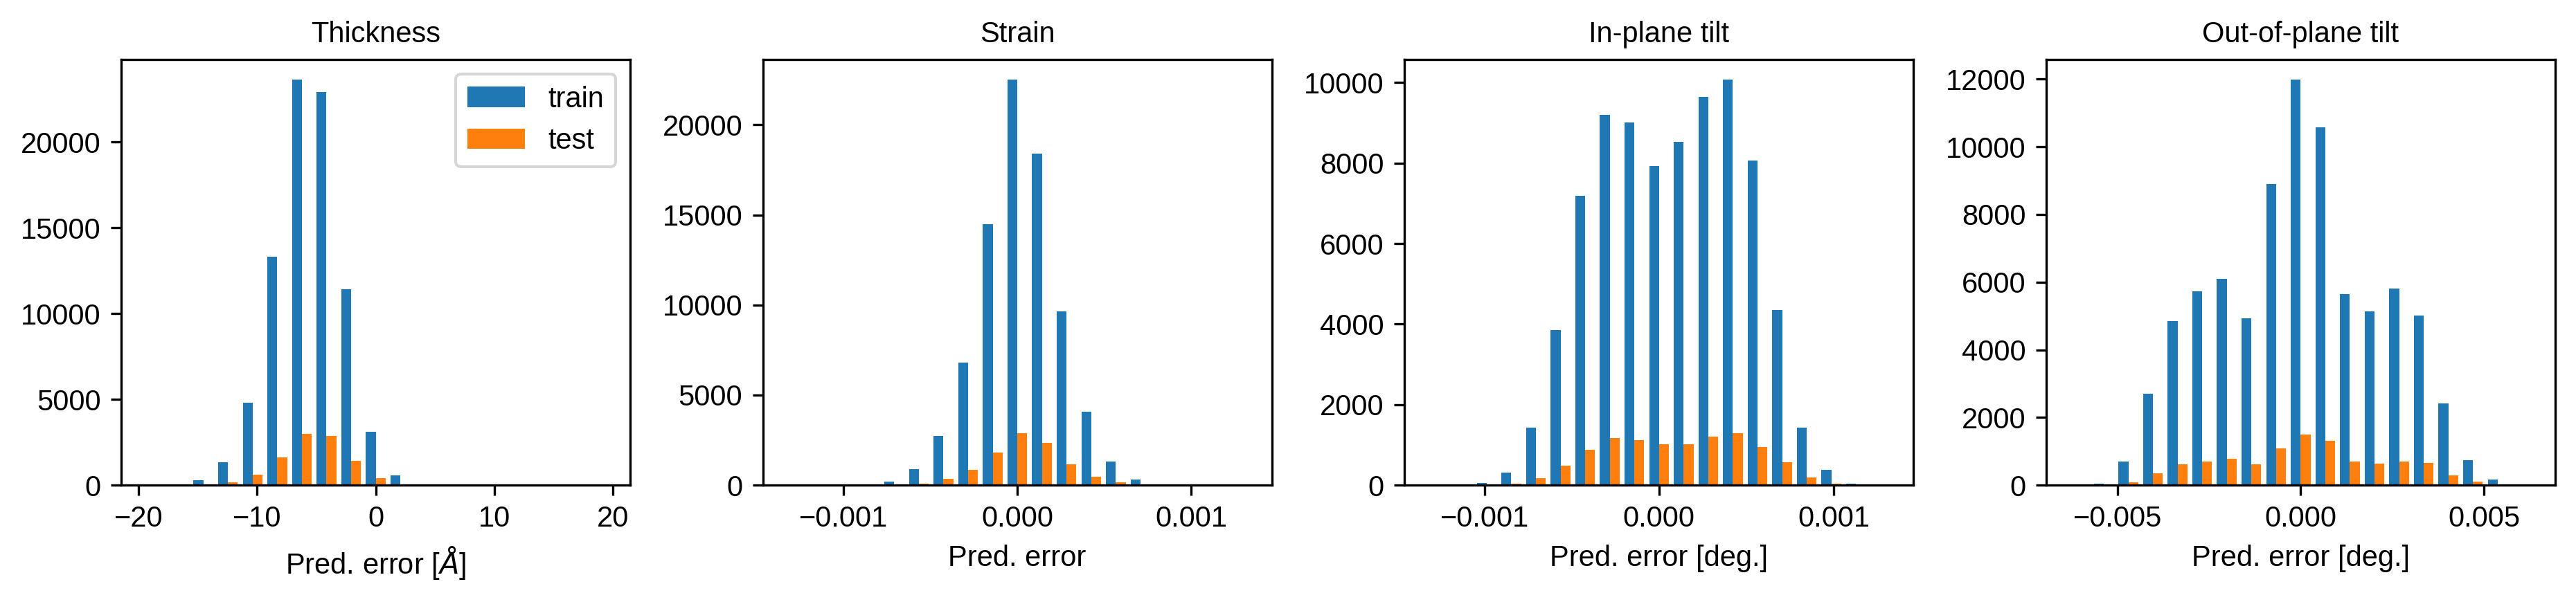

In [29]:
f, ax = plt.subplots(figsize=(12.5, 3), ncols=4)

ax[0].hist([x0, y0], bins0, label=['train', 'test'])
ax[0].set_xlabel('Pred. error [$\AA$]')
ax[0].set_title('Thickness')
ax[0].legend()

ax[1].hist([x1, y1], bins1, label=['train', 'test'])
ax[1].set_xlabel('Pred. error')
ax[1].set_title('Strain')

ax[2].hist([x2, y2], bins2, label=['train', 'test'])
ax[2].set_xlabel('Pred. error [deg.]')
ax[2].set_title('In-plane tilt')

ax[3].hist([x3, y3], bins3, label=['train', 'test'])
ax[3].set_xlabel('Pred. error [deg.]')
ax[3].set_title('Out-of-plane tilt')

plt.tight_layout()

## Trained on experimental data only

In [30]:
cnn_exp = Encoder(1)
cnn_exp.load_state_dict(torch.load(os.path.join('./models/thickness_exp_only', 'best_model_encoder.pth'), 
                                   map_location=torch.device('cpu')))
scale_factor = torch.tensor([np.log(50), np.log(5e-3), np.log(5e-2), np.log(1e-1)])

pred_vals_exp, _ = get_predictions(cnn_exp, dataloader, scale=scale_factor, encoder_only=True)
pred_vals_test_exp, _ = get_predictions(cnn_exp, testloader, scale=scale_factor, encoder_only=True)

cuda:0


0it [00:00, ?it/s]

Total inference time (s):  0.8517005443572998
Average inference time (s):  2.3920890428213928e-05
Inference time error (s):  7.846194221559911e-07
cuda:0


0it [00:00, ?it/s]

Total inference time (s):  0.3372228145599365
Average inference time (s):  2.3620879384362774e-05
Inference time error (s):  1.2031789436470718e-07


In [31]:
pred_thickness = np.reshape(pred_vals_exp[:, 0], (165, 165)) 
pred_strain = np.reshape(pred_vals_exp[:, 1], (165, 165))
pred_strain -= np.mean(pred_strain)
pred_tilt_lr = np.reshape(pred_vals_exp[:, 2], (165, 165))
pred_tilt_lr -= np.mean(pred_tilt_lr)
pred_tilt_ud = np.reshape(pred_vals_exp[:, 3], (165, 165))
pred_tilt_ud -= np.mean(pred_tilt_ud)

test_stats_t_exp, test_stats_s_exp, test_stats_lr_exp, test_stats_ud_exp = combine_stats(test_t, test_s, test_lr, 
                                                                                         test_ud, pred_vals_test_exp)

In [32]:
pred_thickness.mean() + 117 # 117 Angstroms is the nominal average film thickness, measured by RHEED during growth

109.88824040816597

[]

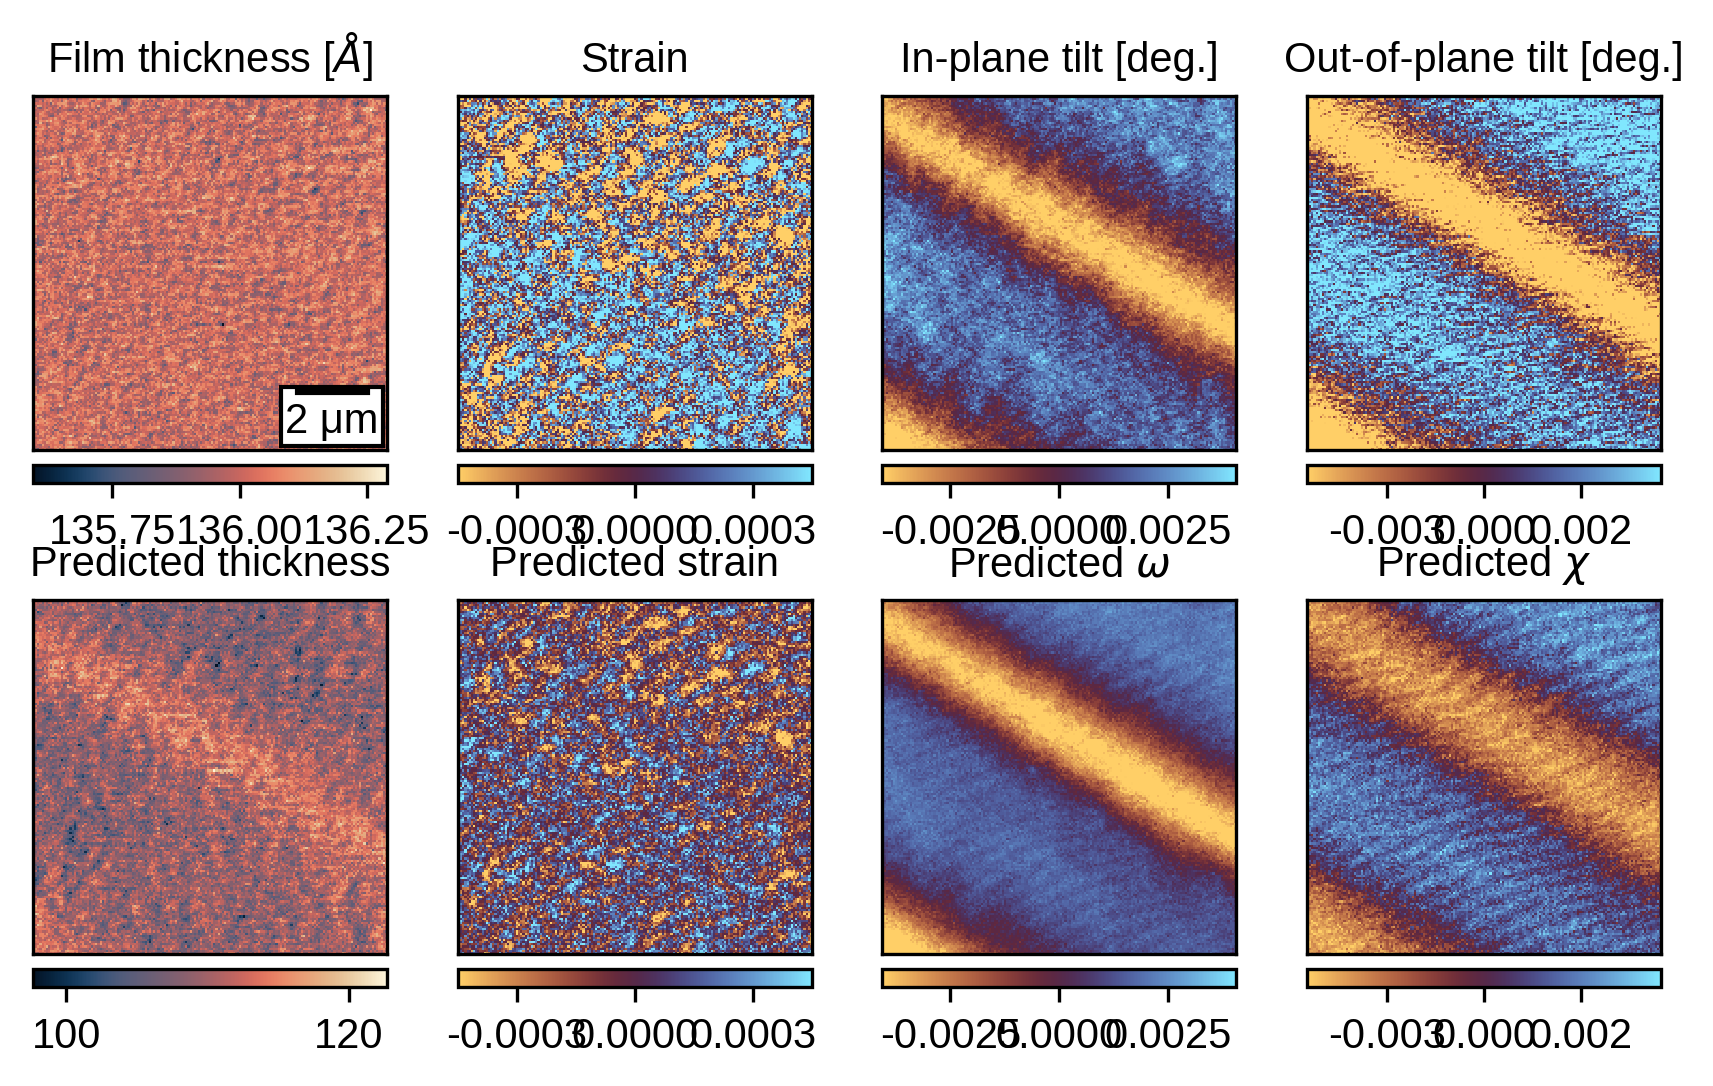

In [33]:
# Figure 4b
matplotlib.rcParams['pdf.fonttype'] = 'truetype'

f, ax = plt.subplots(figsize=(7, 4), nrows=2, ncols=4)

vmin0 = np.mean(pred_thickness) - (2 * np.std(pred_thickness))
vmax0 = np.mean(pred_thickness) + (2 * np.std(pred_thickness))
vmin1 = np.mean(pred_strain) - (2 * np.std(pred_strain))
vmax1 = np.mean(pred_strain) + (2 * np.std(pred_strain))
vmin2 = np.mean(pred_tilt_lr) - (2 * np.std(pred_tilt_lr))
vmax2 = np.mean(pred_tilt_lr) + (2 * np.std(pred_tilt_lr))
vmin3 = np.mean(pred_tilt_ud) - (2 * np.std(pred_tilt_ud))
vmax3 = np.mean(pred_tilt_ud) + (2 * np.std(pred_tilt_ud))

im0 = ax[0, 0].imshow(thickness_fit, interpolation='none', origin='lower', cmap=cmc.lipari)
divider = make_axes_locatable(ax[0, 0])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(im0, cax=cax, orientation='horizontal')
scalebar = AnchoredSizeBar(ax[0, 0].transData, 33, u'2 μm', 'lower right', pad=0.1, color='black', 
                           frameon=True, size_vertical=1)

ax[0, 0].add_artist(scalebar)
ax[0, 0].set_title('Film thickness [$\AA$]')
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

im1 = ax[0, 1].imshow(strain_fit, interpolation='none', origin='lower', cmap=cmc.managua, 
                      vmin=vmin1, vmax=vmax1)
divider = make_axes_locatable(ax[0, 1])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(im1, cax=cax, orientation='horizontal', format='%.4f')
ax[0, 1].set_title('Strain')
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])

im2 = ax[0, 2].imshow(tilt_lr_fit, interpolation='none', origin='lower', cmap=cmc.managua, 
                      vmin=vmin2, vmax=vmax2)
divider = make_axes_locatable(ax[0, 2])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(im2, cax=cax, orientation='horizontal', format='%.4f')
ax[0, 2].set_title('In-plane tilt [deg.]')
ax[0, 2].set_xticks([])
ax[0, 2].set_yticks([])

im3 = ax[0, 3].imshow(tilt_ud_fit, interpolation='none', origin='lower', cmap=cmc.managua, 
                      vmin=vmin3, vmax=vmax3)
divider = make_axes_locatable(ax[0, 3])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(im3, cax=cax, orientation='horizontal', format='%.3f')
ax[0, 3].set_title('Out-of-plane tilt [deg.]')
ax[0, 3].set_xticks([])
ax[0, 3].set_yticks([])

pred0 = ax[1, 0].imshow(pred_thickness+117, interpolation='none', origin='lower', cmap=cmc.lipari)
divider = make_axes_locatable(ax[1, 0])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(pred0, cax=cax, orientation='horizontal')
ax[1, 0].set_title('Predicted thickness')
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])

pred1 = ax[1, 1].imshow(pred_strain, interpolation='none', origin='lower', cmap=cmc.managua, 
                        vmin=vmin1, vmax=vmax1)
divider = make_axes_locatable(ax[1, 1])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(pred1, cax=cax, orientation='horizontal', format='%.4f')
ax[1, 1].set_title('Predicted strain')
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])

pred2 = ax[1, 2].imshow(pred_tilt_lr, interpolation='none', origin='lower', cmap=cmc.managua, 
                        vmin=vmin2, vmax=vmax2)
divider = make_axes_locatable(ax[1, 2])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(pred2, cax=cax, orientation='horizontal', format='%.4f')
ax[1, 2].set_title('Predicted $\omega$')
ax[1, 2].set_xticks([])
ax[1, 2].set_yticks([])

pred3 = ax[1, 3].imshow(pred_tilt_ud, interpolation='none', origin='lower', cmap=cmc.managua, 
                        vmin=vmin3, vmax=vmax3)
divider = make_axes_locatable(ax[1, 3])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(pred3, cax=cax, orientation='horizontal', format='%.3f')
ax[1, 3].set_title('Predicted $\chi$')
ax[1, 3].set_xticks([])
ax[1, 3].set_yticks([])

#f.savefig('fig4b.svg', dpi=300, bbox_inches='tight', transparent=True)

In [34]:
from scipy import stats
print(stats.pearsonr(thickness_fit.flatten(), pred_thickness.flatten())[0])
print(stats.pearsonr(strain_fit.flatten(), pred_strain.flatten())[0])
print(stats.pearsonr(tilt_lr_fit.flatten(), pred_tilt_lr.flatten())[0])
print(stats.pearsonr(tilt_ud_fit.flatten(), pred_tilt_ud.flatten())[0])

0.5541607732470455
0.87621269579022
0.9520293660958564
0.860556061082148


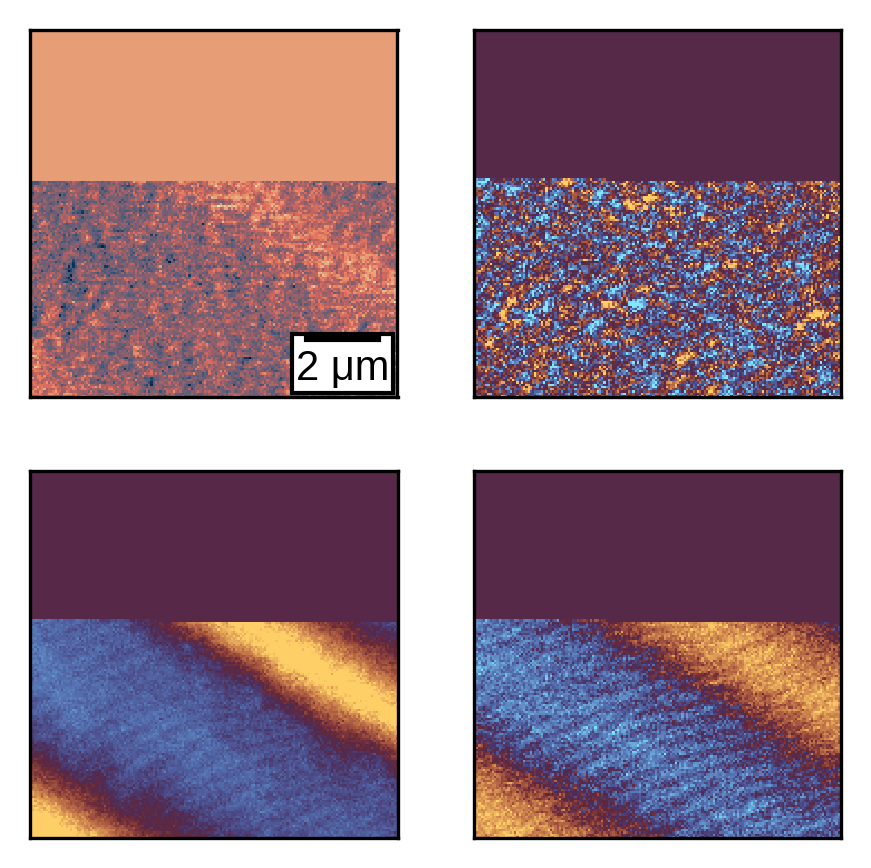

In [39]:
# Fig4b liveplot
live_thickness = pred_vals_exp[:, 0]
live_thickness[16064:] = 0
live_thickness = np.reshape(live_thickness, (165, 165))
live_strain= pred_vals_exp[:, 1] - np.mean(pred_vals_exp[:, 1])
live_strain[16064:] = 0
live_strain = np.reshape(live_strain, (165, 165))
live_tilt_lr = pred_vals_exp[:, 2] - np.mean(pred_vals_exp[:, 2])
live_tilt_lr[16064:] = 0
live_tilt_lr = np.reshape(live_tilt_lr, (165, 165))
live_tilt_ud = pred_vals_exp[:, 3] - np.mean(pred_vals_exp[:, 3])
live_tilt_ud[16064:] = 0
live_tilt_ud = np.reshape(live_tilt_ud, (165, 165))

matplotlib.rcParams['pdf.fonttype'] = 'truetype'

f, ax = plt.subplots(figsize=(3.5, 3.5), nrows=2, ncols=2)

im0 = ax[0, 0].imshow(live_thickness, interpolation='none', origin='lower', cmap=cmc.lipari)
scalebar = AnchoredSizeBar(ax[0, 0].transData, 33, u'2 μm', 'lower right', pad=0.1, color='black', 
                           frameon=True, size_vertical=1)

ax[0, 0].add_artist(scalebar)
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

im1 = ax[0, 1].imshow(live_strain, interpolation='none', origin='lower', cmap=cmc.managua, 
                      vmin=vmin1, vmax=vmax1)
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])

im2 = ax[1, 0].imshow(live_tilt_lr, interpolation='none', origin='lower', cmap=cmc.managua, 
                      vmin=vmin2, vmax=vmax2)
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])

im3 = ax[1, 1].imshow(live_tilt_ud, interpolation='none', origin='lower', cmap=cmc.managua, 
                      vmin=vmin3, vmax=vmax3)
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])
#f.savefig('fig4c.svg', dpi=300, bbox_inches='tight', transparent=True)

## Supplementary

In [33]:
data_folder = '/data/aileen/DONUT_data' # On Kochi

sim_mat = np.load(os.path.join(data_folder, 'sim_SIO_4nm_range.npy')) # With thickness

sim_mat[np.isnan(sim_mat)] = 0
sim_mat /= sim_mat.sum(axis=(4, 5), keepdims=True)

sim_mat = np.reshape(sim_mat,
                     (sim_mat.shape[0]*sim_mat.shape[1]*sim_mat.shape[2]*sim_mat.shape[3], 
                     sim_mat.shape[4], sim_mat.shape[5]))
avg_max = np.mean(sim_mat.max(axis=(1, 2)))

print('Data shape: ', sim_mat.shape)

thickness = np.linspace(97, 137, 11)
strain = np.linspace(-0.005, 0.005, 21)
tilt_lr = np.linspace(-0.05, 0.05, 21)
tilt_ud = np.linspace(-0.1, 0.1, 21)

labels = np.zeros((11, 21, 21, 21, 4))
for p0 in range(labels.shape[0]):
    for p1 in range(labels.shape[1]):
        for p2 in range(labels.shape[2]):
            for p3 in range(labels.shape[3]):
                labels[p0, p1, p2, p3] = np.array([thickness[p0], strain[p1], tilt_lr[p2], tilt_ud[p3]])
labels = np.reshape(labels, (labels.shape[0]*labels.shape[1]*labels.shape[2]*labels.shape[3], 
                             labels.shape[4]))

labels = np.float32(np.around(labels, 5))

print('Labels shape: ', labels.shape)

# Normalize data from 0 to average experimental single shot maximum value
sim_mat_norm = np.zeros(sim_mat.shape)
for i in range(sim_mat_norm.shape[0]):
    sim_mat_norm[i] = (sim_mat[i] / avg_max) * 7
print('Normalized min. and max.: ', np.min(sim_mat_norm), np.max(sim_mat_norm))

# Add Poisson noise 
rng = np.random.default_rng()
for i in range(sim_mat_norm.shape[0]):
    sim_mat_norm[i] = rng.poisson(sim_mat_norm[i])

sim_mat_norm = sim_mat_norm.astype('float32')
print('Data type: ', sim_mat_norm.dtype)

print('Loading simulated scan data')
sim_sample = np.load(os.path.join(data_folder, 'sim_sample_thickness.npy')).astype(np.float32)
sim_sample = np.reshape(sim_sample, (sim_sample.shape[0]*sim_sample.shape[1], sim_sample.shape[2], sim_sample.shape[3]))
sim_sample[np.isnan(sim_sample)] = 0
sim_sample /= sim_sample.sum(axis=(1, 2), keepdims=True)
avg_max_sample = np.mean(sim_sample.max(axis=(1, 2)))
sim_sample = (sim_sample / avg_max_sample) * 7
for i in range(sim_sample.shape[0]):
    sim_sample[i] = rng.poisson(sim_sample[i])

Data shape:  (101871, 64, 64)
Labels shape:  (101871, 4)
Normalized min. and max.:  0.0 9.573053950739874
Data type:  float32
Loading simulated scan data


In [34]:
diff_dataset_7 = DiffDataset(data=sim_mat_norm, params=labels, transform=ToTensor())
sim_dataset_7 = DiffDataset(data=sim_sample, params=None, transform=ToTensor())

subsets_7 = torch.utils.data.random_split(diff_dataset_7, [0.8, 0.1, 0.1], generator=generator0)
testloader_all = DataLoader(subsets_7[2], batch_size=BATCH_SIZE, shuffle=False)
simloader_all = DataLoader(sim_dataset_7, batch_size=BATCH_SIZE, shuffle=False)

In [35]:
# Trained on combination of data
cnn_all = Encoder(1)
cnn_all.load_state_dict(torch.load(os.path.join('./models/thickness_all', 'best_model_encoder.pth'), 
                                   map_location=torch.device('cpu')))
scale_factor = torch.tensor([np.log(50), np.log(5e-3), np.log(5e-2), np.log(1e-1)])

pred_vals_exp_all, _ = get_predictions(cnn_all, dataloader, scale=scale_factor, encoder_only=True)
pred_vals_test_all, gt_vals_test_all = get_predictions(cnn_all, testloader_all, scale=scale_factor, encoder_only=True)
pred_vals_sim_all, _ = get_predictions(cnn_all, simloader_all, scale=scale_factor, encoder_only=True)

pred_thickness_all = np.reshape(pred_vals_exp_all[:, 0], (165, 165)) 
pred_strain_all = np.reshape(pred_vals_exp_all[:, 1], (165, 165))
pred_strain_all -= np.mean(pred_strain_all)
pred_tilt_lr_all = np.reshape(pred_vals_exp_all[:, 2], (165, 165))
pred_tilt_lr_all -= np.mean(pred_tilt_lr_all)
pred_tilt_ud_all = np.reshape(pred_vals_exp_all[:, 3], (165, 165))
pred_tilt_ud_all -= np.mean(pred_tilt_ud_all)

pred_sim_thickness_all = np.reshape(pred_vals_sim_all[:, 0], (64, 64))
pred_sim_strain_all = np.reshape(pred_vals_sim_all[:, 1], (64, 64))
pred_sim_tilt_lr_all = np.reshape(pred_vals_sim_all[:, 2], (64, 64))
pred_sim_tilt_ud_all = np.reshape(pred_vals_sim_all[:, 3], (64, 64))

test_t, test_s, test_lr, test_ud = make_idx_dict(gt_vals_test_all)
print('Test set indices: ', test_make_idx_dict(test_t), test_make_idx_dict(test_s), 
      test_make_idx_dict(test_lr), test_make_idx_dict(test_ud))

test_stats_t_all, test_stats_s_all, test_stats_lr_all, test_stats_ud_all = combine_stats(test_t, test_s, test_lr, 
                                                                                         test_ud, pred_vals_test_all)

cuda:0


0it [00:00, ?it/s]

Total inference time (s):  0.8487703800201416
Average inference time (s):  2.3815648775574162e-05
Inference time error (s):  8.396638233614125e-07
cuda:0


0it [00:00, ?it/s]

Total inference time (s):  0.3303849697113037
Average inference time (s):  2.35571223459426e-05
Inference time error (s):  1.2979045177829984e-07
cuda:0


0it [00:00, ?it/s]

Total inference time (s):  0.13025903701782227
Average inference time (s):  2.3217963390663023e-05
Inference time error (s):  1.340996044819056e-07
Test set indices:  10187 10187 10187 10187


In [36]:
pred_thickness_all.mean() + 117, pred_sim_thickness_all.mean() + 117 # underestimated, overestimated

(100.1377308917043, 128.29307774865146)

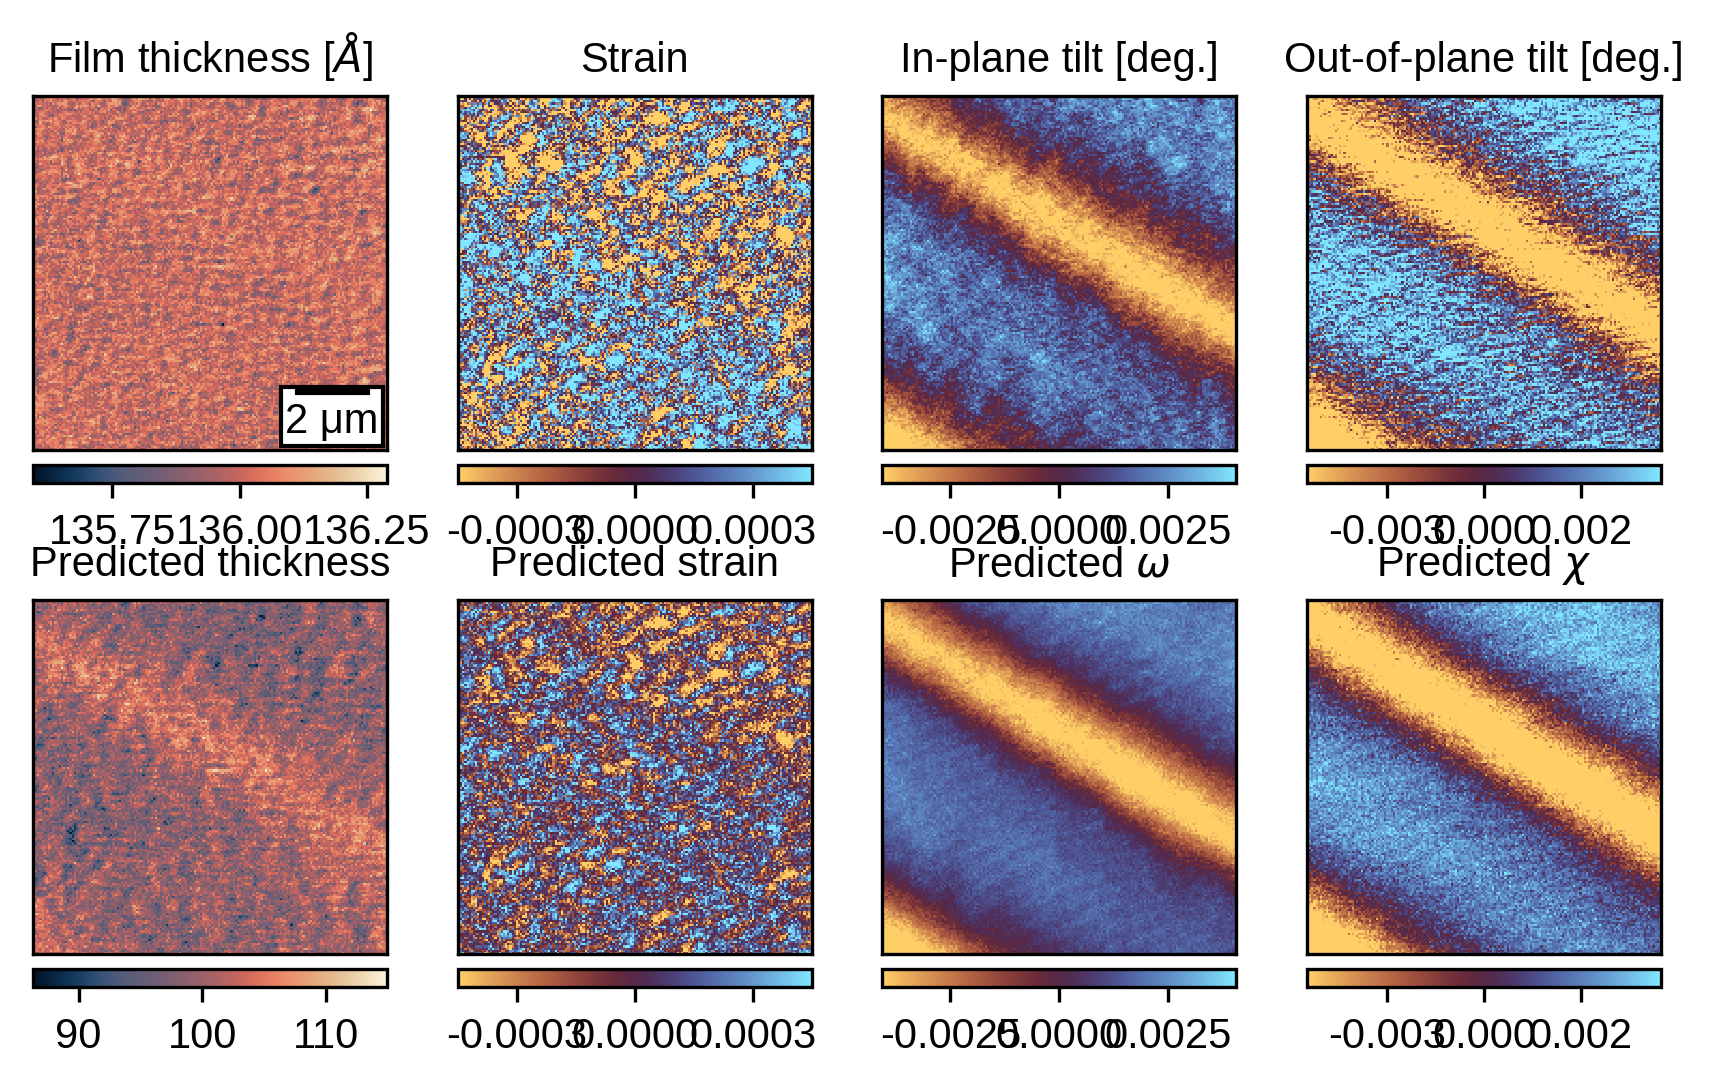

In [38]:
# Figure S6a
matplotlib.rcParams['pdf.fonttype'] = 'truetype'

f, ax = plt.subplots(figsize=(7, 4), nrows=2, ncols=4)

vmin0 = np.mean(pred_thickness) - (2 * np.std(pred_thickness))
vmax0 = np.mean(pred_thickness) + (2 * np.std(pred_thickness))
vmin1 = np.mean(pred_strain) - (2 * np.std(pred_strain))
vmax1 = np.mean(pred_strain) + (2 * np.std(pred_strain))
vmin2 = np.mean(pred_tilt_lr) - (2 * np.std(pred_tilt_lr))
vmax2 = np.mean(pred_tilt_lr) + (2 * np.std(pred_tilt_lr))
vmin3 = np.mean(pred_tilt_ud) - (2 * np.std(pred_tilt_ud))
vmax3 = np.mean(pred_tilt_ud) + (2 * np.std(pred_tilt_ud))

im0 = ax[0, 0].imshow(thickness_fit, interpolation='none', origin='lower', cmap=cmc.lipari)
divider = make_axes_locatable(ax[0, 0])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(im0, cax=cax, orientation='horizontal')
scalebar = AnchoredSizeBar(ax[0, 0].transData, 33, u'2 μm', 'lower right', pad=0.1, color='black', 
                           frameon=True, size_vertical=1)

ax[0, 0].add_artist(scalebar)
ax[0, 0].set_title('Film thickness [$\AA$]')
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

im1 = ax[0, 1].imshow(strain_fit, interpolation='none', origin='lower', cmap=cmc.managua, 
                      vmin=vmin1, vmax=vmax1)
divider = make_axes_locatable(ax[0, 1])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(im1, cax=cax, orientation='horizontal', format='%.4f')
ax[0, 1].set_title('Strain')
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])

im2 = ax[0, 2].imshow(tilt_lr_fit, interpolation='none', origin='lower', cmap=cmc.managua, 
                      vmin=vmin2, vmax=vmax2)
divider = make_axes_locatable(ax[0, 2])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(im2, cax=cax, orientation='horizontal', format='%.4f')
ax[0, 2].set_title('In-plane tilt [deg.]')
ax[0, 2].set_xticks([])
ax[0, 2].set_yticks([])

im3 = ax[0, 3].imshow(tilt_ud_fit, interpolation='none', origin='lower', cmap=cmc.managua, 
                      vmin=vmin3, vmax=vmax3)
divider = make_axes_locatable(ax[0, 3])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(im3, cax=cax, orientation='horizontal', format='%.3f')
ax[0, 3].set_title('Out-of-plane tilt [deg.]')
ax[0, 3].set_xticks([])
ax[0, 3].set_yticks([])

pred0 = ax[1, 0].imshow(pred_thickness_all+117, interpolation='none', origin='lower', cmap=cmc.lipari)
divider = make_axes_locatable(ax[1, 0])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(pred0, cax=cax, orientation='horizontal')
ax[1, 0].set_title('Predicted thickness')
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])

pred1 = ax[1, 1].imshow(pred_strain_all, interpolation='none', origin='lower', cmap=cmc.managua, 
                        vmin=vmin1, vmax=vmax1)
divider = make_axes_locatable(ax[1, 1])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(pred1, cax=cax, orientation='horizontal', format='%.4f')
ax[1, 1].set_title('Predicted strain')
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])

pred2 = ax[1, 2].imshow(pred_tilt_lr_all, interpolation='none', origin='lower', cmap=cmc.managua, 
                        vmin=vmin2, vmax=vmax2)
divider = make_axes_locatable(ax[1, 2])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(pred2, cax=cax, orientation='horizontal', format='%.4f')
ax[1, 2].set_title('Predicted $\omega$')
ax[1, 2].set_xticks([])
ax[1, 2].set_yticks([])

pred3 = ax[1, 3].imshow(pred_tilt_ud_all, interpolation='none', origin='lower', cmap=cmc.managua, 
                        vmin=vmin3, vmax=vmax3)
divider = make_axes_locatable(ax[1, 3])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(pred3, cax=cax, orientation='horizontal', format='%.3f')
ax[1, 3].set_title('Predicted $\chi$')
ax[1, 3].set_xticks([])
ax[1, 3].set_yticks([])

#f.savefig('figs6a.svg', dpi=300, bbox_inches='tight', transparent=True)

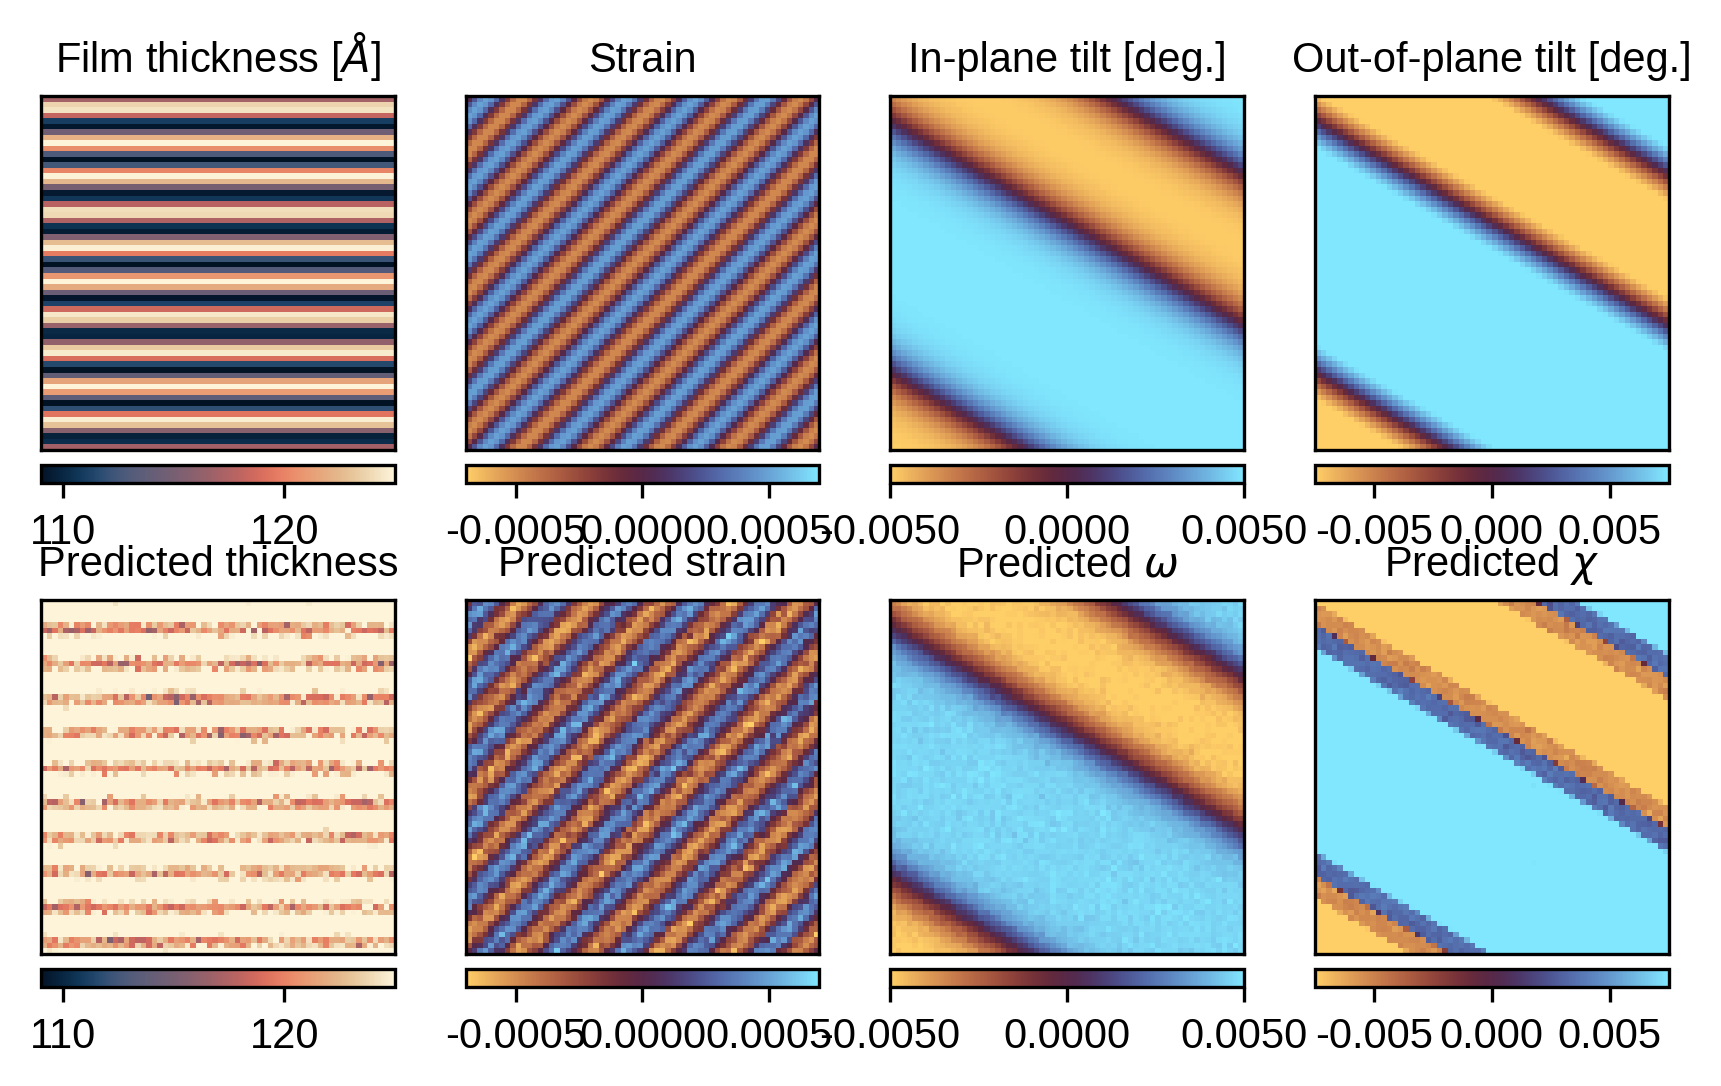

In [39]:
# Figure S6b
matplotlib.rcParams['pdf.fonttype'] = 'truetype'

f, ax = plt.subplots(figsize=(7, 4), nrows=2, ncols=4)

vmin0 = 109
vmax0 = 125
vmin1 = -0.0007 # np.mean(pred_sim_strain) - (2 * np.std(pred_sim_strain))
vmax1 = 0.0007 # np.mean(pred_sim_strain) + (2 * np.std(pred_sim_strain))
vmin2 = -0.005 # np.mean(pred_sim_tilt_lr) - (2 * np.std(pred_sim_tilt_lr))
vmax2 = 0.005 # np.mean(pred_sim_tilt_lr) + (2 * np.std(pred_sim_tilt_lr))
vmin3 = -0.0075 # np.mean(pred_sim_tilt_ud) - (2 * np.std(pred_sim_tilt_ud))
vmax3 = 0.0075 # np.mean(pred_sim_tilt_ud) + (2 * np.std(pred_sim_tilt_ud))

im0 = ax[0, 0].imshow(gt_thickness, interpolation='none', cmap=cmc.lipari, vmin=vmin0, vmax=vmax0)
divider = make_axes_locatable(ax[0, 0])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(im0, cax=cax, orientation='horizontal')
ax[0, 0].set_title('Film thickness [$\AA$]')
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

im1 = ax[0, 1].imshow(gt_strain, interpolation='none', cmap=cmc.managua, 
                      vmin=vmin1, vmax=vmax1)
divider = make_axes_locatable(ax[0, 1])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(im1, cax=cax, orientation='horizontal', format='%.4f')
ax[0, 1].set_title('Strain')
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])

im2 = ax[0, 2].imshow(gt_tilt_lr, interpolation='none', cmap=cmc.managua, 
                      vmin=vmin2, vmax=vmax2)
divider = make_axes_locatable(ax[0, 2])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(im2, cax=cax, orientation='horizontal', format='%.4f')
ax[0, 2].set_title('In-plane tilt [deg.]')
ax[0, 2].set_xticks([])
ax[0, 2].set_yticks([])

im3 = ax[0, 3].imshow(gt_tilt_ud, interpolation='none', cmap=cmc.managua, 
                      vmin=vmin3, vmax=vmax3)
divider = make_axes_locatable(ax[0, 3])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(im3, cax=cax, orientation='horizontal', format='%.3f')
ax[0, 3].set_title('Out-of-plane tilt [deg.]')
ax[0, 3].set_xticks([])
ax[0, 3].set_yticks([])

pred0 = ax[1, 0].imshow(pred_sim_thickness_all+117, interpolation='none', cmap=cmc.lipari, vmin=vmin0, vmax=vmax0)
divider = make_axes_locatable(ax[1, 0])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(pred0, cax=cax, orientation='horizontal')
ax[1, 0].set_title('Predicted thickness')
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])

pred1 = ax[1, 1].imshow(pred_sim_strain_all, interpolation='none', cmap=cmc.managua, 
                        vmin=vmin1, vmax=vmax1)
divider = make_axes_locatable(ax[1, 1])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(pred1, cax=cax, orientation='horizontal', format='%.4f')
ax[1, 1].set_title('Predicted strain')
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])

pred2 = ax[1, 2].imshow(pred_sim_tilt_lr_all, interpolation='none', cmap=cmc.managua, 
                        vmin=vmin2, vmax=vmax2)
divider = make_axes_locatable(ax[1, 2])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(pred2, cax=cax, orientation='horizontal', format='%.4f')
ax[1, 2].set_title('Predicted $\omega$')
ax[1, 2].set_xticks([])
ax[1, 2].set_yticks([])

pred3 = ax[1, 3].imshow(pred_sim_tilt_ud_all, interpolation='none', cmap=cmc.managua, 
                        vmin=vmin3, vmax=vmax3)
divider = make_axes_locatable(ax[1, 3])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(pred3, cax=cax, orientation='horizontal', format='%.3f')
ax[1, 3].set_title('Predicted $\chi$')
ax[1, 3].set_xticks([])
ax[1, 3].set_yticks([])
#f.savefig('figs6b.svg', dpi=300, bbox_inches='tight', transparent=True)

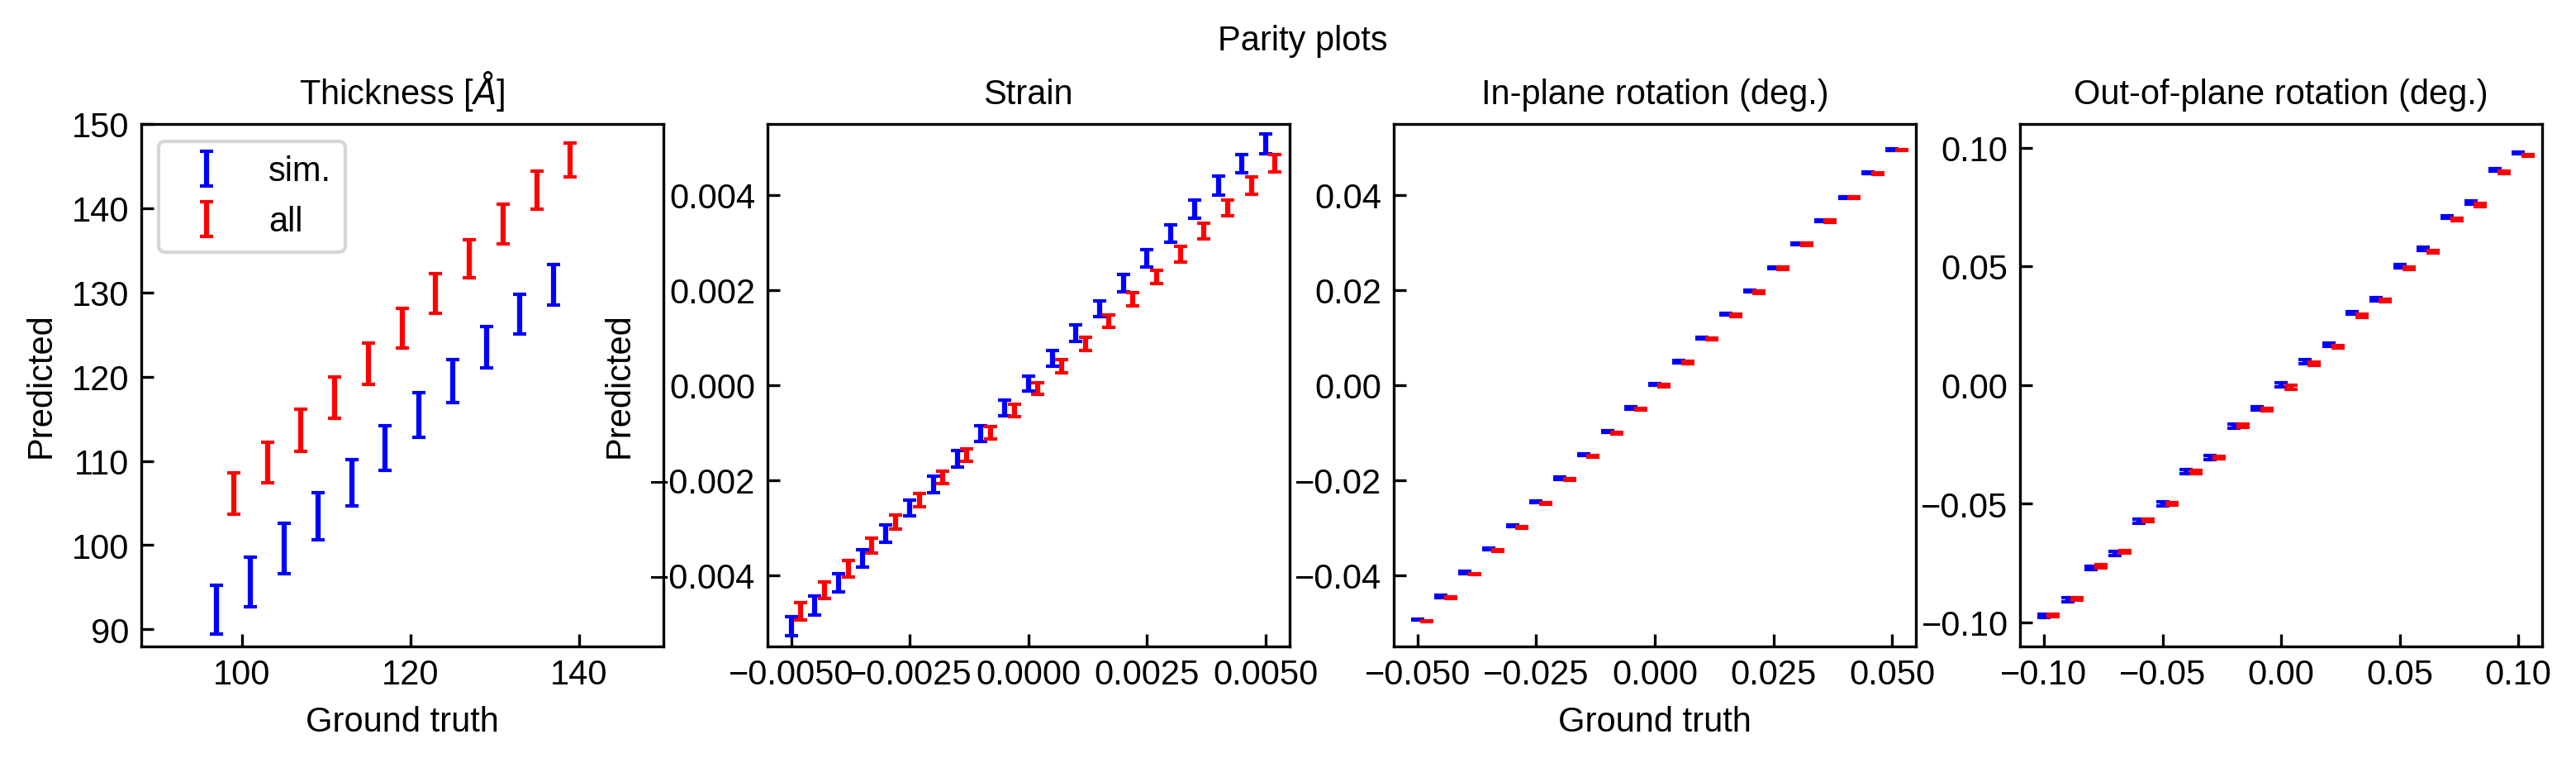

In [40]:
# Fig. S6c
matplotlib.rcParams['pdf.fonttype'] = 'truetype'

f, ax = plt.subplots(figsize=(12.5, 3), ncols=4)

ax[0].errorbar(thickness_label_range, test_stats_t[:, 0]+117, 
               yerr=test_stats_t[:, 1], label='sim.', fmt='none', capsize=2, color='blue')
ax[0].errorbar(thickness_label_range+2, test_stats_t_all[:, 0]+117, 
               yerr=test_stats_t_all[:, 1], label='all', fmt='none', capsize=2, color='red')
ax[0].set_xlim([88, 150])
ax[0].set_ylim([88, 150])
ax[0].set_xlabel('Ground truth')
ax[0].set_ylabel('Predicted')
ax[0].set_title('Thickness [$\AA$]')
ax[0].set_aspect(1)
ax[0].tick_params(which='both', direction='in')
ax[0].legend()

ax[1].errorbar(np.linspace(-0.005, 0.005, 21), test_stats_s[:, 0], yerr=test_stats_s[:, 1], 
               label='sim.', fmt='none', capsize=2, color='blue')
ax[1].errorbar(np.linspace(-0.005, 0.005, 21)+0.0002, test_stats_s_all[:, 0], 
               yerr=test_stats_s_all[:, 1], label='all', fmt='none', capsize=2, color='red')
ax[1].set_ylabel('Predicted')
ax[1].set_xlim([-0.0055, 0.0055])
ax[1].set_ylim([-0.0055, 0.0055])
ax[1].set_title('Strain')
ax[1].set_aspect(1)
ax[1].tick_params(which='both', direction='in')

ax[2].errorbar(np.linspace(-0.05, 0.05, 21), test_stats_lr[:, 0], yerr=test_stats_lr[:, 1], 
               label='sim.', fmt='none', capsize=2, color='blue')
ax[2].errorbar(np.linspace(-0.05, 0.05, 21)+0.002, test_stats_lr_all[:, 0], yerr=test_stats_lr_all[:, 1], 
               label='all', fmt='none', capsize=2, color='red')
ax[2].set_xlabel('Ground truth')
ax[2].set_xlim([-0.055, 0.055])
ax[2].set_ylim([-0.055, 0.055])
ax[2].set_title('In-plane rotation (deg.)')
ax[2].tick_params(which='both', direction='in')
ax[2].set_aspect(1)

ax[3].errorbar(np.linspace(-0.1, 0.1, 21), test_stats_ud[:, 0], yerr=test_stats_ud[:, 1], 
               label='sim.', fmt='none', capsize=2, color='blue')
ax[3].errorbar(np.linspace(-0.1, 0.1, 21)+0.004, test_stats_ud_all[:, 0], yerr=test_stats_ud_all[:, 1], 
               label='all', fmt='none', capsize=2, color='red')
ax[3].set_title('Out-of-plane rotation (deg.)')
ax[3].set_xlim([-0.11, 0.11])
ax[3].set_ylim([-0.11, 0.11])
ax[3].tick_params(which='both', direction='in')
ax[3].set_aspect(1)

f.suptitle('Parity plots')
#f.savefig('figs6c.svg', dpi=300, bbox_inches='tight', transparent=True)

In [41]:
# Thickness prediction has large uncertainty due to detector pixel size in reciprocal space and fringe spacing
# Thus, it only makes sense to predict thickness for non-uniform films or when you have no other methods of 
# characterizing it 

data_folder = '/data/aileen/DONUT_data' # On Kochi

sim_mat = np.load(os.path.join(data_folder, 'sim_SIO_50nm_range.npy')) # Optimal range at measurement conditions

sim_mat[np.isnan(sim_mat)] = 0
sim_mat /= sim_mat.sum(axis=(4, 5), keepdims=True)

sim_mat = np.reshape(sim_mat,
                     (sim_mat.shape[0]*sim_mat.shape[1]*sim_mat.shape[2]*sim_mat.shape[3], 
                     sim_mat.shape[4], sim_mat.shape[5]))
avg_max = np.mean(sim_mat.max(axis=(1, 2)))

print('Data shape: ', sim_mat.shape)

thickness = np.linspace(300, 800, 11)
strain = np.linspace(-0.005, 0.005, 21)
tilt_lr = np.linspace(-0.05, 0.05, 21)
tilt_ud = np.linspace(-0.1, 0.1, 21)

labels = np.zeros((11, 21, 21, 21, 4))
for p0 in range(labels.shape[0]):
    for p1 in range(labels.shape[1]):
        for p2 in range(labels.shape[2]):
            for p3 in range(labels.shape[3]):
                labels[p0, p1, p2, p3] = np.array([thickness[p0], strain[p1], tilt_lr[p2], tilt_ud[p3]])
labels = np.reshape(labels, (labels.shape[0]*labels.shape[1]*labels.shape[2]*labels.shape[3], 
                             labels.shape[4]))

labels = np.float32(np.around(labels, 5))

print('Labels shape: ', labels.shape)

# Normalize data from 0 to average experimental single shot maximum value
sim_mat_norm = np.zeros(sim_mat.shape)
for i in range(sim_mat_norm.shape[0]):
    sim_mat_norm[i] = (sim_mat[i] / avg_max) * 10
print('Normalized min. and max.: ', np.min(sim_mat_norm), np.max(sim_mat_norm))

# Add Poisson noise 
rng = np.random.default_rng()
for i in range(sim_mat_norm.shape[0]):
    sim_mat_norm[i] = rng.poisson(sim_mat_norm[i])

sim_mat_norm = sim_mat_norm.astype('float32')
print('Data type: ', sim_mat_norm.dtype)

print('Loading simulated scan data')
sim_sample = np.load(os.path.join(data_folder, 'sim_sample_thickness_high.npy')).astype(np.float32)
sim_sample = np.reshape(sim_sample, (sim_sample.shape[0]*sim_sample.shape[1], sim_sample.shape[2], sim_sample.shape[3]))
sim_sample[np.isnan(sim_sample)] = 0
sim_sample /= sim_sample.sum(axis=(1, 2), keepdims=True)
avg_max_sample = np.mean(sim_sample.max(axis=(1, 2)))
sim_sample = (sim_sample / avg_max_sample) * 10
for i in range(sim_sample.shape[0]):
    sim_sample[i] = rng.poisson(sim_sample[i])
    
gt_thickness_high = np.load(os.path.join(data_folder, 'gt_thickness_high.npy'))

Data shape:  (101871, 64, 64)
Labels shape:  (101871, 4)
Normalized min. and max.:  0.0 17.09473209328333
Data type:  float32
Loading simulated scan data


In [42]:
diff_dataset_high = DiffDataset(data=sim_mat_norm, params=labels, transform=ToTensor())
sim_dataset_high = DiffDataset(data=sim_sample, params=None, transform=ToTensor())

subsets_high = torch.utils.data.random_split(diff_dataset_high, [0.8, 0.1, 0.1], generator=generator0)
trainloader_high = DataLoader(subsets_high[0], batch_size=BATCH_SIZE, shuffle=True)
testloader_high = DataLoader(subsets_high[2], batch_size=BATCH_SIZE, shuffle=False)
simloader_high = DataLoader(sim_dataset_high, batch_size=BATCH_SIZE, shuffle=False)

In [43]:
cnn_high = Encoder(1)
cnn_high.load_state_dict(torch.load(os.path.join('./models/high_thickness_sim', 'best_model_encoder.pth'), 
                                   map_location=torch.device('cpu')))
scale_factor = torch.tensor([np.log(500), np.log(5e-3), np.log(5e-2), np.log(1e-1)])

pred_vals_train_high, gt_vals_train_high = get_predictions(cnn_high, trainloader_high, scale=scale_factor, encoder_only=True)
pred_vals_test_high, gt_vals_test_high = get_predictions(cnn_high, testloader_high, scale=scale_factor, encoder_only=True)
pred_vals_sim_high, _ = get_predictions(cnn_high, simloader_high, scale=scale_factor, encoder_only=True)

pred_sim_thickness_high = np.reshape(pred_vals_sim_high[:, 0], (64, 64))
pred_sim_strain_high = np.reshape(pred_vals_sim_high[:, 1], (64, 64))
pred_sim_tilt_lr_high = np.reshape(pred_vals_sim_high[:, 2], (64, 64))
pred_sim_tilt_ud_high = np.reshape(pred_vals_sim_high[:, 3], (64, 64))

thickness_label_range = np.linspace(300, 800, 11)
print('Thickness label range: ', thickness_label_range)
strain_label_range = np.linspace(-0.005, 0.005, 21)
print('Strain label range: ', strain_label_range)
tilt_lr_label_range = np.linspace(-0.05, 0.05, 21)
print('Tilt_lr label range: ', tilt_lr_label_range)
tilt_ud_label_range = np.linspace(-0.1, 0.1, 21)
print('Tilt_ud label range: ', tilt_ud_label_range)

train_t, train_s, train_lr, train_ud = make_idx_dict(gt_vals_train_high)
print('Train set indices: ', test_make_idx_dict(train_t), test_make_idx_dict(train_s), 
      test_make_idx_dict(train_lr), test_make_idx_dict(train_ud))
test_t, test_s, test_lr, test_ud = make_idx_dict(gt_vals_test_high)
print('Test set indices: ', test_make_idx_dict(test_t), test_make_idx_dict(test_s), 
      test_make_idx_dict(test_lr), test_make_idx_dict(test_ud))

train_stats_t_high, train_stats_s_high, train_stats_lr_high, train_stats_ud_high = combine_stats(train_t, train_s, 
                                                                                                 train_lr, train_ud, 
                                                                                                 pred_vals_train_high)
test_stats_t_high, test_stats_s_high, test_stats_lr_high, test_stats_ud_high = combine_stats(test_t, test_s, test_lr, 
                                                                                         test_ud, pred_vals_test_high)

cuda:0


0it [00:00, ?it/s]

Total inference time (s):  2.6230671405792236
Average inference time (s):  2.370745729124518e-05
Inference time error (s):  5.804396661989356e-07
cuda:0


0it [00:00, ?it/s]

Total inference time (s):  0.3291282653808594
Average inference time (s):  2.3531140225708106e-05
Inference time error (s):  1.2546924052493135e-07
cuda:0


0it [00:00, ?it/s]

Total inference time (s):  0.13140201568603516
Average inference time (s):  2.3270728158169106e-05
Inference time error (s):  1.2995178479841139e-07
Thickness label range:  [300. 350. 400. 450. 500. 550. 600. 650. 700. 750. 800.]
Strain label range:  [-0.005  -0.0045 -0.004  -0.0035 -0.003  -0.0025 -0.002  -0.0015 -0.001
 -0.0005  0.      0.0005  0.001   0.0015  0.002   0.0025  0.003   0.0035
  0.004   0.0045  0.005 ]
Tilt_lr label range:  [-0.05  -0.045 -0.04  -0.035 -0.03  -0.025 -0.02  -0.015 -0.01  -0.005
  0.     0.005  0.01   0.015  0.02   0.025  0.03   0.035  0.04   0.045
  0.05 ]
Tilt_ud label range:  [-0.1  -0.09 -0.08 -0.07 -0.06 -0.05 -0.04 -0.03 -0.02 -0.01  0.    0.01
  0.02  0.03  0.04  0.05  0.06  0.07  0.08  0.09  0.1 ]
Train set indices:  81497 81497 81497 81497
Test set indices:  10187 10187 10187 10187


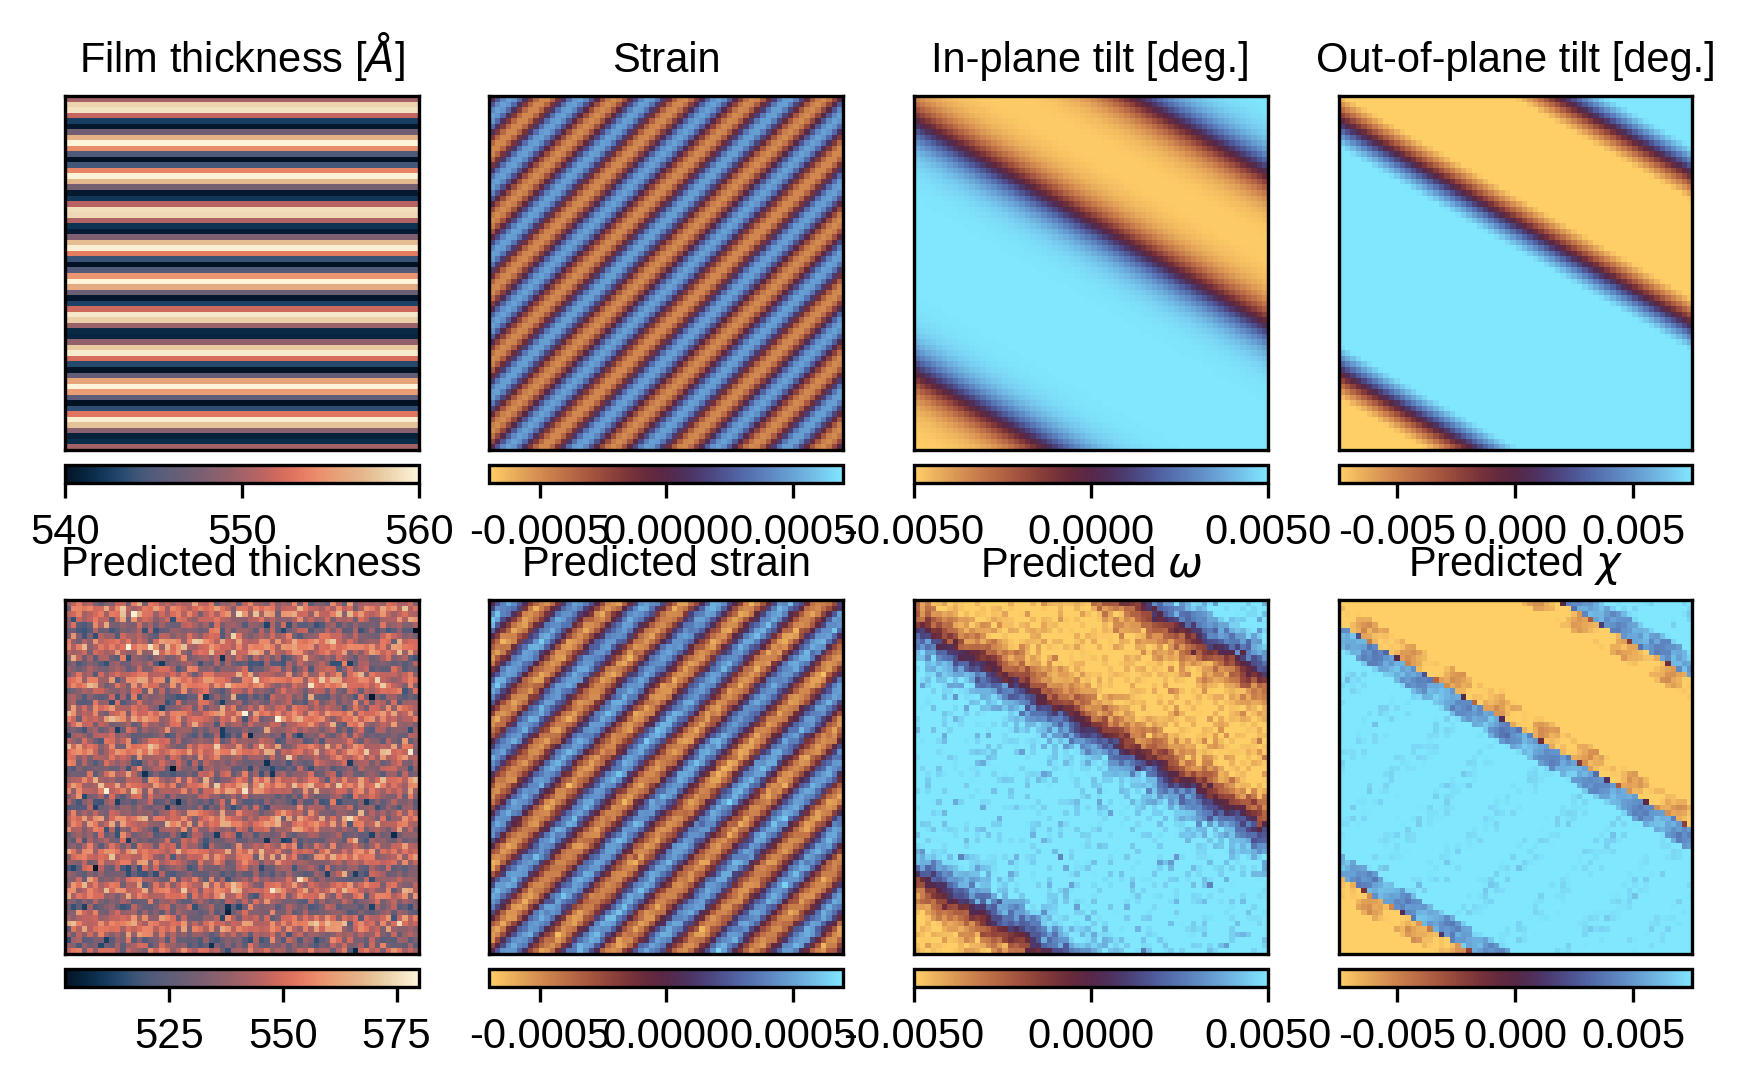

In [44]:
# Figure S7a
matplotlib.rcParams['pdf.fonttype'] = 'truetype'

f, ax = plt.subplots(figsize=(7, 4), nrows=2, ncols=4)

vmin0 = 540
vmax0 = 560
vmin1 = -0.0007 # np.mean(pred_sim_strain) - (2 * np.std(pred_sim_strain))
vmax1 = 0.0007 # np.mean(pred_sim_strain) + (2 * np.std(pred_sim_strain))
vmin2 = -0.005 # np.mean(pred_sim_tilt_lr) - (2 * np.std(pred_sim_tilt_lr))
vmax2 = 0.005 # np.mean(pred_sim_tilt_lr) + (2 * np.std(pred_sim_tilt_lr))
vmin3 = -0.0075 # np.mean(pred_sim_tilt_ud) - (2 * np.std(pred_sim_tilt_ud))
vmax3 = 0.0075 # np.mean(pred_sim_tilt_ud) + (2 * np.std(pred_sim_tilt_ud))

im0 = ax[0, 0].imshow(gt_thickness_high, interpolation='none', cmap=cmc.lipari, vmin=vmin0, vmax=vmax0)
divider = make_axes_locatable(ax[0, 0])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(im0, cax=cax, orientation='horizontal')
ax[0, 0].set_title('Film thickness [$\AA$]')
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

im1 = ax[0, 1].imshow(gt_strain, interpolation='none', cmap=cmc.managua, 
                      vmin=vmin1, vmax=vmax1)
divider = make_axes_locatable(ax[0, 1])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(im1, cax=cax, orientation='horizontal', format='%.4f')
ax[0, 1].set_title('Strain')
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])

im2 = ax[0, 2].imshow(gt_tilt_lr, interpolation='none', cmap=cmc.managua, 
                      vmin=vmin2, vmax=vmax2)
divider = make_axes_locatable(ax[0, 2])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(im2, cax=cax, orientation='horizontal', format='%.4f')
ax[0, 2].set_title('In-plane tilt [deg.]')
ax[0, 2].set_xticks([])
ax[0, 2].set_yticks([])

im3 = ax[0, 3].imshow(gt_tilt_ud, interpolation='none', cmap=cmc.managua, 
                      vmin=vmin3, vmax=vmax3)
divider = make_axes_locatable(ax[0, 3])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(im3, cax=cax, orientation='horizontal', format='%.3f')
ax[0, 3].set_title('Out-of-plane tilt [deg.]')
ax[0, 3].set_xticks([])
ax[0, 3].set_yticks([])

pred0 = ax[1, 0].imshow(pred_sim_thickness_high+550, interpolation='none', cmap=cmc.lipari)
divider = make_axes_locatable(ax[1, 0])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(pred0, cax=cax, orientation='horizontal')
ax[1, 0].set_title('Predicted thickness')
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])

pred1 = ax[1, 1].imshow(pred_sim_strain_high, interpolation='none', cmap=cmc.managua, 
                        vmin=vmin1, vmax=vmax1)
divider = make_axes_locatable(ax[1, 1])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(pred1, cax=cax, orientation='horizontal', format='%.4f')
ax[1, 1].set_title('Predicted strain')
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])

pred2 = ax[1, 2].imshow(pred_sim_tilt_lr_high, interpolation='none', cmap=cmc.managua, 
                        vmin=vmin2, vmax=vmax2)
divider = make_axes_locatable(ax[1, 2])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(pred2, cax=cax, orientation='horizontal', format='%.4f')
ax[1, 2].set_title('Predicted $\omega$')
ax[1, 2].set_xticks([])
ax[1, 2].set_yticks([])

pred3 = ax[1, 3].imshow(pred_sim_tilt_ud_high, interpolation='none', cmap=cmc.managua, 
                        vmin=vmin3, vmax=vmax3)
divider = make_axes_locatable(ax[1, 3])
cax = divider.append_axes('bottom', size='5%', pad=0.05)
f.colorbar(pred3, cax=cax, orientation='horizontal', format='%.3f')
ax[1, 3].set_title('Predicted $\chi$')
ax[1, 3].set_xticks([])
ax[1, 3].set_yticks([])
#f.savefig('figs7a.svg', dpi=300, bbox_inches='tight', transparent=True)

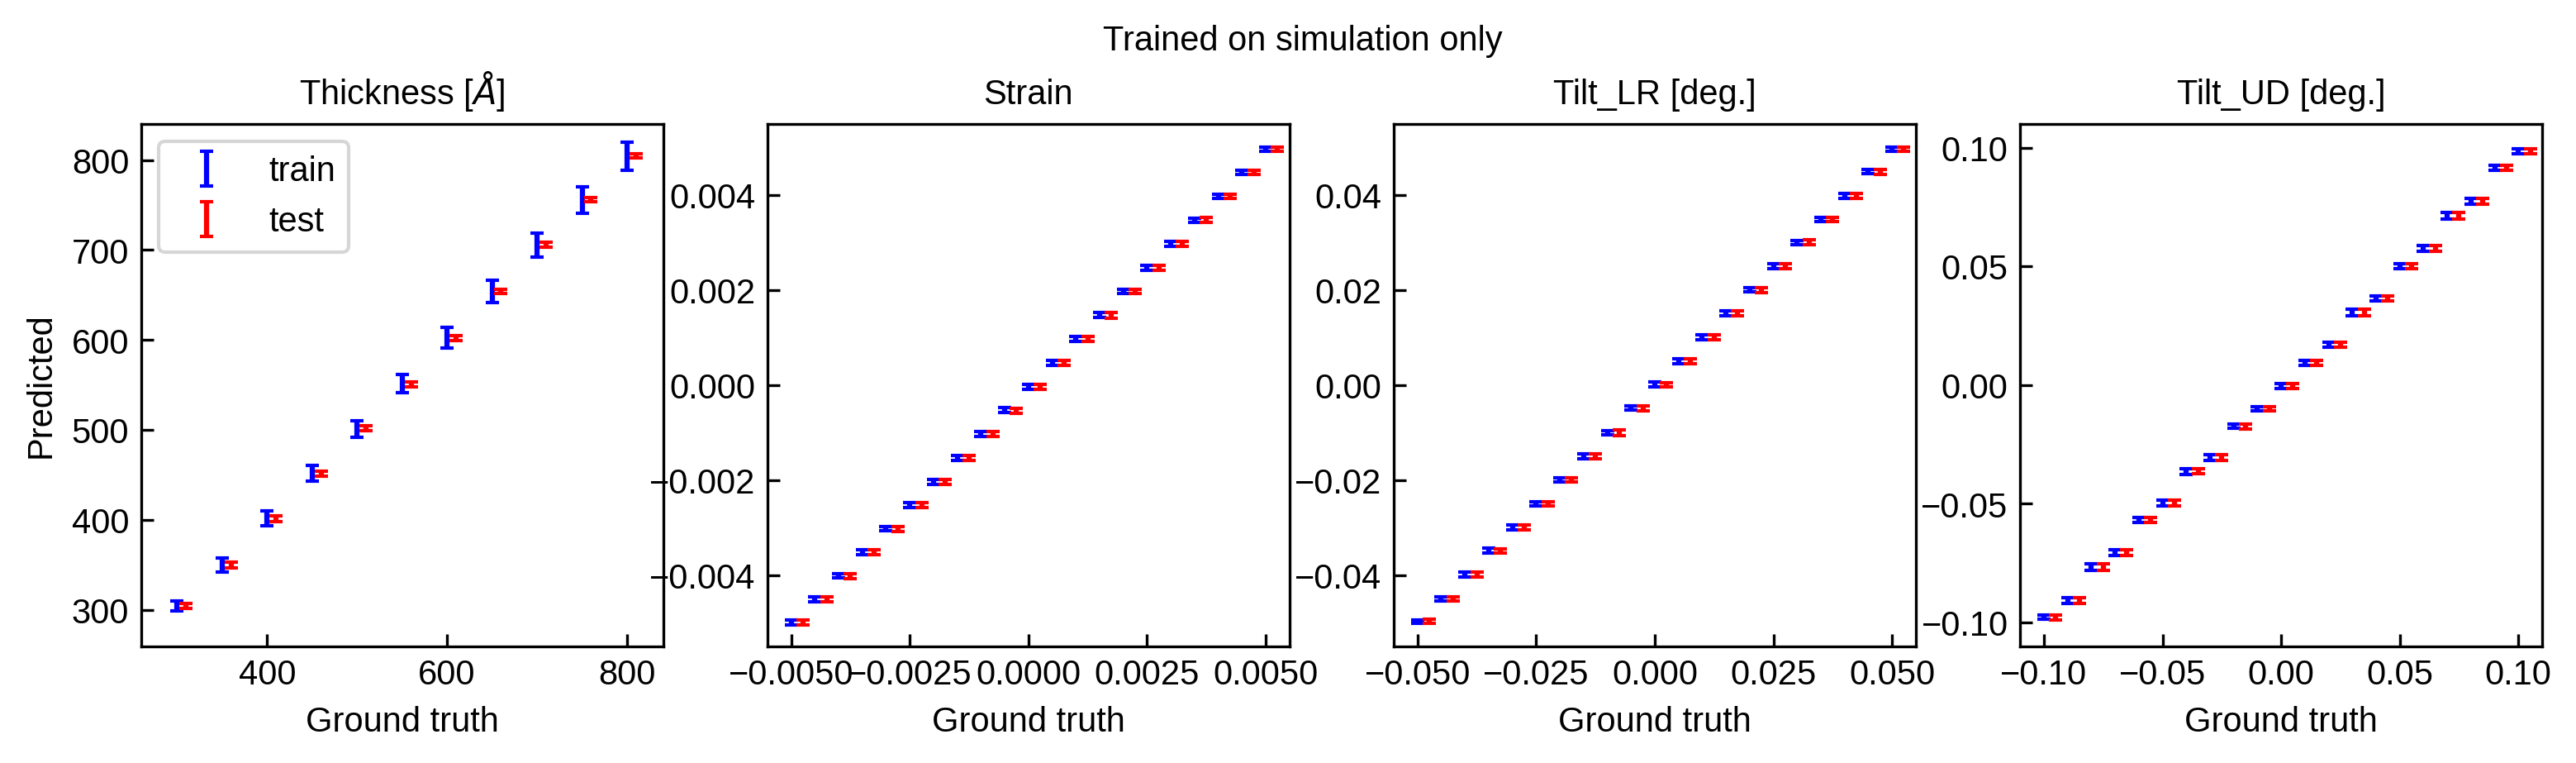

In [46]:
# Figure S7b
matplotlib.rcParams['pdf.fonttype'] = 'truetype'

f, ax = plt.subplots(figsize=(12.5, 3), ncols=4)

ax[0].errorbar(thickness_label_range, train_stats_t_high[:, 0]+550, yerr=train_stats_t_high[:, 1], 
               label='train', fmt='none', capsize=2, color='blue')
ax[0].errorbar(thickness_label_range+10, test_stats_t_high[:, 0]+550, 
               yerr=test_stats_t[:, 1], label='test', fmt='none', capsize=2, color='red')
ax[0].set_xlim([260, 840])
ax[0].set_ylim([260, 840])
ax[0].set_xlabel('Ground truth')
ax[0].set_ylabel('Predicted')
ax[0].set_title('Thickness [$\AA$]')
ax[0].set_aspect(1)
ax[0].tick_params(which='both', direction='in')
ax[0].legend()

ax[1].errorbar(np.linspace(-0.005, 0.005, 21), train_stats_s_high[:, 0], yerr=train_stats_s_high[:, 1], 
               label='train', fmt='none', capsize=2, color='blue')
ax[1].errorbar(np.linspace(-0.005, 0.005, 21)+0.00025, test_stats_s_high[:, 0], yerr=test_stats_s_high[:, 1], 
               label='test', fmt='none', capsize=2, color='red')
ax[1].set_xlim([-0.0055, 0.0055])
ax[1].set_ylim([-0.0055, 0.0055])
ax[1].set_xlabel('Ground truth')
ax[1].set_title('Strain')
ax[1].tick_params(which='both', direction='in')
ax[1].set_aspect(1)

ax[2].errorbar(np.linspace(-0.05, 0.05, 21), train_stats_lr_high[:, 0], yerr=train_stats_lr_high[:, 1], 
               label='train', fmt='none', capsize=2, color='blue')
ax[2].errorbar(np.linspace(-0.05, 0.05, 21)+0.0025, test_stats_lr_high[:, 0], yerr=test_stats_lr_high[:, 1], 
               label='test', fmt='none', capsize=2, color='red')
ax[2].set_xlim([-0.055, 0.055])
ax[2].set_ylim([-0.055, 0.055])
ax[2].set_xlabel('Ground truth')
ax[2].set_title('Tilt_LR [deg.]')
ax[2].tick_params(which='both', direction='in')
ax[2].set_aspect(1)

ax[3].errorbar(np.linspace(-0.1, 0.1, 21), train_stats_ud_high[:, 0], yerr=train_stats_ud_high[:, 1], 
               label='train', fmt='none', capsize=2, color='blue')
ax[3].errorbar(np.linspace(-0.1, 0.1, 21)+0.005, test_stats_ud_high[:, 0], yerr=test_stats_ud_high[:, 1], 
               label='test', fmt='none', capsize=2, color='red')
ax[3].set_xlim([-0.11, 0.11])
ax[3].set_ylim([-0.11, 0.11])
ax[3].set_xlabel('Ground truth')
ax[3].set_title('Tilt_UD [deg.]')
ax[3].tick_params(which='both', direction='in')
ax[3].set_aspect(1)

f.suptitle('Trained on simulation only')
#f.savefig('figs7b.svg', dpi=300, bbox_inches='tight', transparent=True)

In [47]:
x0 = (pred_vals_train_high[:, 0]+550) - gt_vals_train_high[:, 0]
y0 = (pred_vals_test_high[:, 0]+550) - gt_vals_test_high[:, 0]
range0 = np.max([np.abs(x0.min()), np.abs(x0.max()), np.abs(y0.min()), np.abs(y0.max())])
bins0 = np.linspace(-range0, range0, 20)

x1 = pred_vals_train_high[:, 1] - gt_vals_train_high[:, 1]
y1 = pred_vals_test_high[:, 1] - gt_vals_test_high[:, 1]
range1 = np.max([np.abs(x1.min()), np.abs(x1.max()), np.abs(y1.min()), np.abs(y1.max())])
bins1 = np.linspace(-range1, range1, 20)

x2 = pred_vals_train_high[:, 2] - gt_vals_train_high[:, 2]
y2 = pred_vals_test_high[:, 2] - gt_vals_test_high[:, 2]
range2 = np.max([np.abs(x2.min()), np.abs(x2.max()), np.abs(y2.min()), np.abs(y2.max())])
bins2 = np.linspace(-range2, range2, 20)

x3 = pred_vals_train_high[:, 3] - gt_vals_train_high[:, 3]
y3 = pred_vals_test_high[:, 3] - gt_vals_test_high[:, 3]
range3 = np.max([np.abs(x3.min()), np.abs(x3.max()), np.abs(y3.min()), np.abs(y3.max())])
bins3 = np.linspace(-range3, range3, 20)

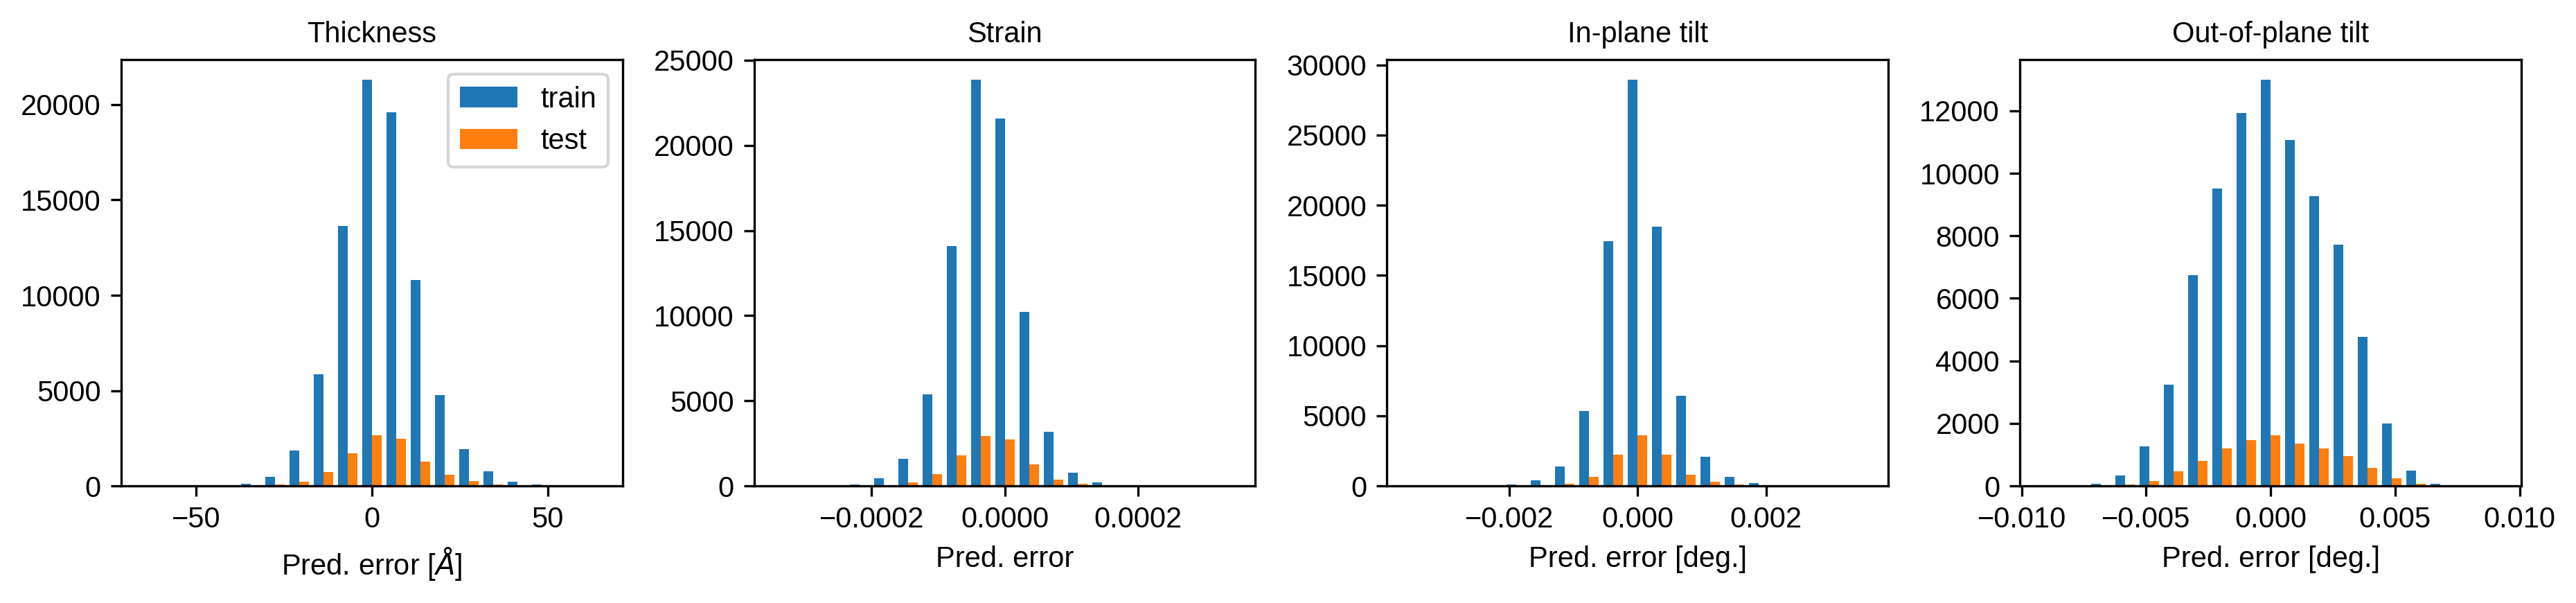

In [48]:
f, ax = plt.subplots(figsize=(12.5, 3), ncols=4)

ax[0].hist([x0, y0], bins0, label=['train', 'test'])
ax[0].set_xlabel('Pred. error [$\AA$]')
ax[0].set_title('Thickness')
ax[0].legend()

ax[1].hist([x1, y1], bins1, label=['train', 'test'])
ax[1].set_xlabel('Pred. error')
ax[1].set_title('Strain')

ax[2].hist([x2, y2], bins2, label=['train', 'test'])
ax[2].set_xlabel('Pred. error [deg.]')
ax[2].set_title('In-plane tilt')

ax[3].hist([x3, y3], bins3, label=['train', 'test'])
ax[3].set_xlabel('Pred. error [deg.]')
ax[3].set_title('Out-of-plane tilt')

plt.tight_layout()